<h1 align="center"><span style='font-family:arial'>Farm Relief Customer Segmentation Analysis</h1>

<h3 align="center"><span style='font-family:arial'>February 2023</h3>

In this project we are going to focus on farmer produce sellers and buyers in Nigeria(and neighbouring countries). We will examine some demographic characteristics of the group, such as age, income bracket, occupation etc. Then we will select five features, and create a clustering model to divide consumers into subgroups. Finally, we will create some visualizations to highlight the differences between these subgroups.

In this project, we're going to work with data from the [Farm Relief](https://forms.gle/nH7jb1RyWptCrzSV8) google form. The form tracks the demographic, financial and opinion information about individuals in Nigeria. The survey was conducted a month ago and it is still ongoing.

# Objective

The aim of this project is to use unsupervised learning, specifically clustering to do customer segmentation.

We will:

    Compare characteristics across subgroups using a side-by-side bar chart.
    Build a k-means clustering model.
    Conduct feature selection for clustering.
    Reduce high-dimensional data using principal component analysis (PCA).
    Design, build and deploy a FastAPI web application.

- Libraries

In [64]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

## Importing The File

In [2]:
farm = pd.read_csv('farm_relief.csv')
print("farm shape:", farm.shape)
farm.head()

farm shape: (59, 17)


,Age range,Age,Gender,Occupation,Marital status,Income,Monthly Household income,"Location e.g Lagos, Nigeria",Device type,Most preferred delivery method,Are you a farmer?,"If yes, What farming system do you have?",What farm produce do you buy or sell? (You can give a list),Would you like an online platform where you can buy or sell farm products and not feel cheated?,Do you know of any platform that provides you with the service mentioned above?,"If yes, please give a name",What features would you be looking forward to on such a digital platform?
0,18 - 25,21,Female,Student,Single,#5000,"< #50,000",Modakeke,Android,Home Delivery,No,NaN,Garri\nRice\nPepper\nOnion\nVegetables,Yes,No,NaN,NaN
1,50 and above,57,Female,Student,Married,"#120,000","#100,000 - #200,000",Osun,Android,Home Delivery,No,NaN,"Pepper, Vegetables, Plantain, Charcoal, Yam fl...",Yes,No,NaN,"Prompt Response, Pricing"
2,50 and above,57,Male,Farmer,Married,"#155,000","#100,000 - #200,000",Osun,Android,Home Delivery,Yes,Small Scale,Cocoa,Yes,No,NaN,More Profit
3,18 - 25,23,Male,Student,Single,"#15,000","< #50,000",Ekiti,Android,Home Delivery,No,NaN,"Vegetables,Rice",Yes,Maybe,NaN,NaN
4,26 - 35,28,Male,Freelance copywriter,Single,"#300,000","#200,000 - #500,000",Ibadan,Android,Home Delivery,No,NaN,"Vegetables,Grains",Yes,No,NaN,"Pricing, Friendly user interface, Impressive l..."


## Data Cleaning

- change headers

In [3]:
farm.rename(columns={
    'Age range':'Age Range',
    'Marital status':'Marital Status',
    'Monthly Household income':'Monthly Household Income',
    'Location e.g Lagos, Nigeria':'Location',
    'Device type':'Device Type',
    'Most preferred delivery method':'Delivery Method',
    'Are you a farmer?':'Farmer',
    'If yes, What farming system do you have?':'Farming System',
    'What farm produce do you buy or sell? (You can give a list)':'Farm Produce',
    'Would you like an online platform where you can buy or sell farm products and not feel cheated?':'Online Platform',
    'Do you know of any platform that provides you with the service mentioned above?':'Alternative Platform Knowledge',
    'If yes, please give a name':'Platform Name',
    'What features would you be looking forward to on such a digital platform?':'Digital Platform Features',    
}, inplace=True)

- make copy of original DataFrame with amended column names

In [4]:
data = farm.copy()

In [5]:
data.head(5)

,Age Range,Age,Gender,Occupation,Marital status,Income,Monthly Household Income,Location,Device Type,Delivery Method,Farmer,Farming System,Farm Produce,Online Platform,Alternative Platform Knowledge,Platform Name,Digital Platform Features
0,18 - 25,21,Female,Student,Single,#5000,"< #50,000",Modakeke,Android,Home Delivery,No,NaN,Garri\nRice\nPepper\nOnion\nVegetables,Yes,No,NaN,NaN
1,50 and above,57,Female,Student,Married,"#120,000","#100,000 - #200,000",Osun,Android,Home Delivery,No,NaN,"Pepper, Vegetables, Plantain, Charcoal, Yam fl...",Yes,No,NaN,"Prompt Response, Pricing"
2,50 and above,57,Male,Farmer,Married,"#155,000","#100,000 - #200,000",Osun,Android,Home Delivery,Yes,Small Scale,Cocoa,Yes,No,NaN,More Profit
3,18 - 25,23,Male,Student,Single,"#15,000","< #50,000",Ekiti,Android,Home Delivery,No,NaN,"Vegetables,Rice",Yes,Maybe,NaN,NaN
4,26 - 35,28,Male,Freelance copywriter,Single,"#300,000","#200,000 - #500,000",Ibadan,Android,Home Delivery,No,NaN,"Vegetables,Grains",Yes,No,NaN,"Pricing, Friendly user interface, Impressive l..."


- remove # and , from `Monthly Household Income` values

In [6]:
data['Monthly Household Income'] = (data['Monthly Household Income']
                   .str.replace('#','', regex=False)
                   .str.replace(',', '')
                   )

- remove # and , from `Income` values and change data type to float

In [7]:
data['Income'] = (data['Income']
                   .str.replace('#','', regex=False)
                   .str.replace(',', '')
                   .astype(float)
                   )

- replace \n with space in the `Farm Produce`

In [8]:
data['Farm Produce'] = (data['Farm Produce']
                  .str.replace('\n',',', regex=False)
                  )

- missing values percentage

In [9]:
data.isnull().sum()/len(data)

Age Range                         0.000000
Age                               0.000000
Gender                            0.000000
Occupation                        0.152542
Marital status                    0.000000
Income                            0.000000
Monthly Household Income          0.000000
Location                          0.000000
Device Type                       0.000000
Delivery Method                   0.000000
Farmer                            0.000000
Farming System                    0.661017
Farm Produce                      0.000000
Online Platform                   0.016949
Alternative Platform Knowledge    0.000000
Platform Name                     0.847458
Digital Platform Features         0.525424
dtype: float64

 **Occupation**, **Farming System**, **Online Platform**, **Platform Name** and **Digital Platform Features** columns have missing values.

- information

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age Range                       59 non-null     object 
 1   Age                             59 non-null     int64  
 2   Gender                          59 non-null     object 
 3   Occupation                      50 non-null     object 
 4   Marital status                  59 non-null     object 
 5   Income                          59 non-null     float64
 6   Monthly Household Income        59 non-null     object 
 7   Location                        59 non-null     object 
 8   Device Type                     59 non-null     object 
 9   Delivery Method                 59 non-null     object 
 10  Farmer                          59 non-null     object 
 11  Farming System                  20 non-null     object 
 12  Farm Produce                    59 non

    > We will drop the `Farming System` and `Platform Name` columns as they have a lot of missing values and fill the NaN with 'Not Specified'.

In [11]:
data.drop(columns=['Farming System', 'Platform Name'], inplace=True)

In [12]:
cols = ['Occupation', 'Online Platform', 'Digital Platform Features']
data[cols] = data[cols].fillna('Not Specified')

In [13]:
# re check missing values
data.isnull().sum()

Age Range                         0
Age                               0
Gender                            0
Occupation                        0
Marital status                    0
Income                            0
Monthly Household Income          0
Location                          0
Device Type                       0
Delivery Method                   0
Farmer                            0
Farm Produce                      0
Online Platform                   0
Alternative Platform Knowledge    0
Digital Platform Features         0
dtype: int64

- Saving cleaned data to csv

In [14]:
data.to_csv('farm_relief_clean.csv', index=False)

# Wrangling

# Exploration

In [50]:
# Setting the theme
sns.set_theme()
# For image quality of the graphics
sns.set(rc = {"figure.dpi":350})
# For size of the graphics
sns.set(rc = {"figure.figsize":(6,3)})

In [51]:
age_groups = data['Age Range'].unique()
print("Age Groups:", age_groups)

Age Groups: ['18 - 25' '50 and above' '26 - 35' '35 - 49']


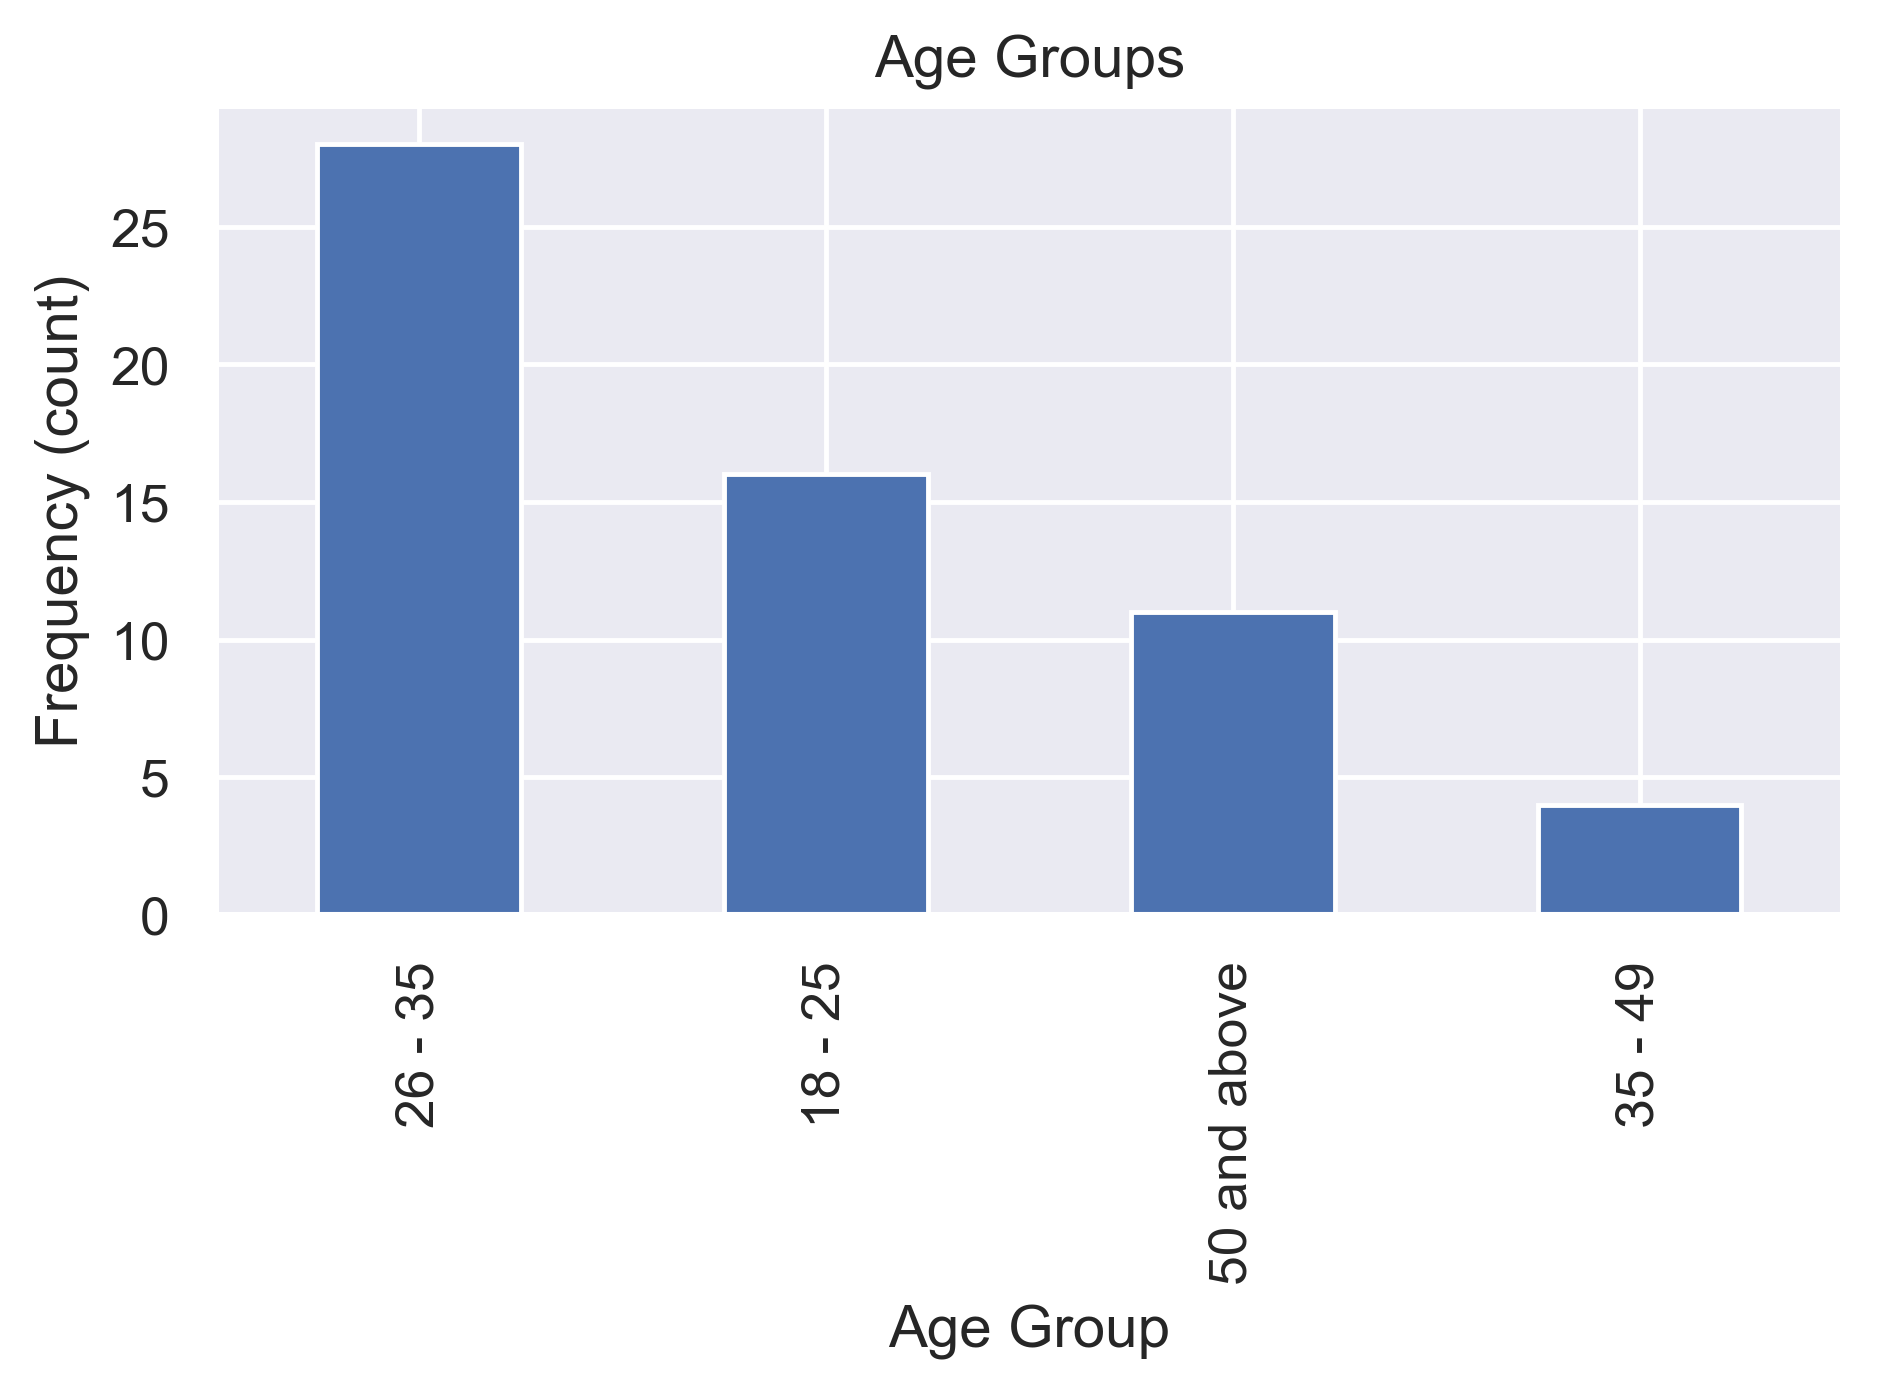

In [52]:
age_cl_value_counts = data['Age Range'].value_counts()

# Bar plot of `age_cl_value_counts`
age_cl_value_counts.plot(
    kind ='bar', 
    xlabel = 'Age Group',
    ylabel = 'Frequency (count)',
    title = 'Age Groups'
);

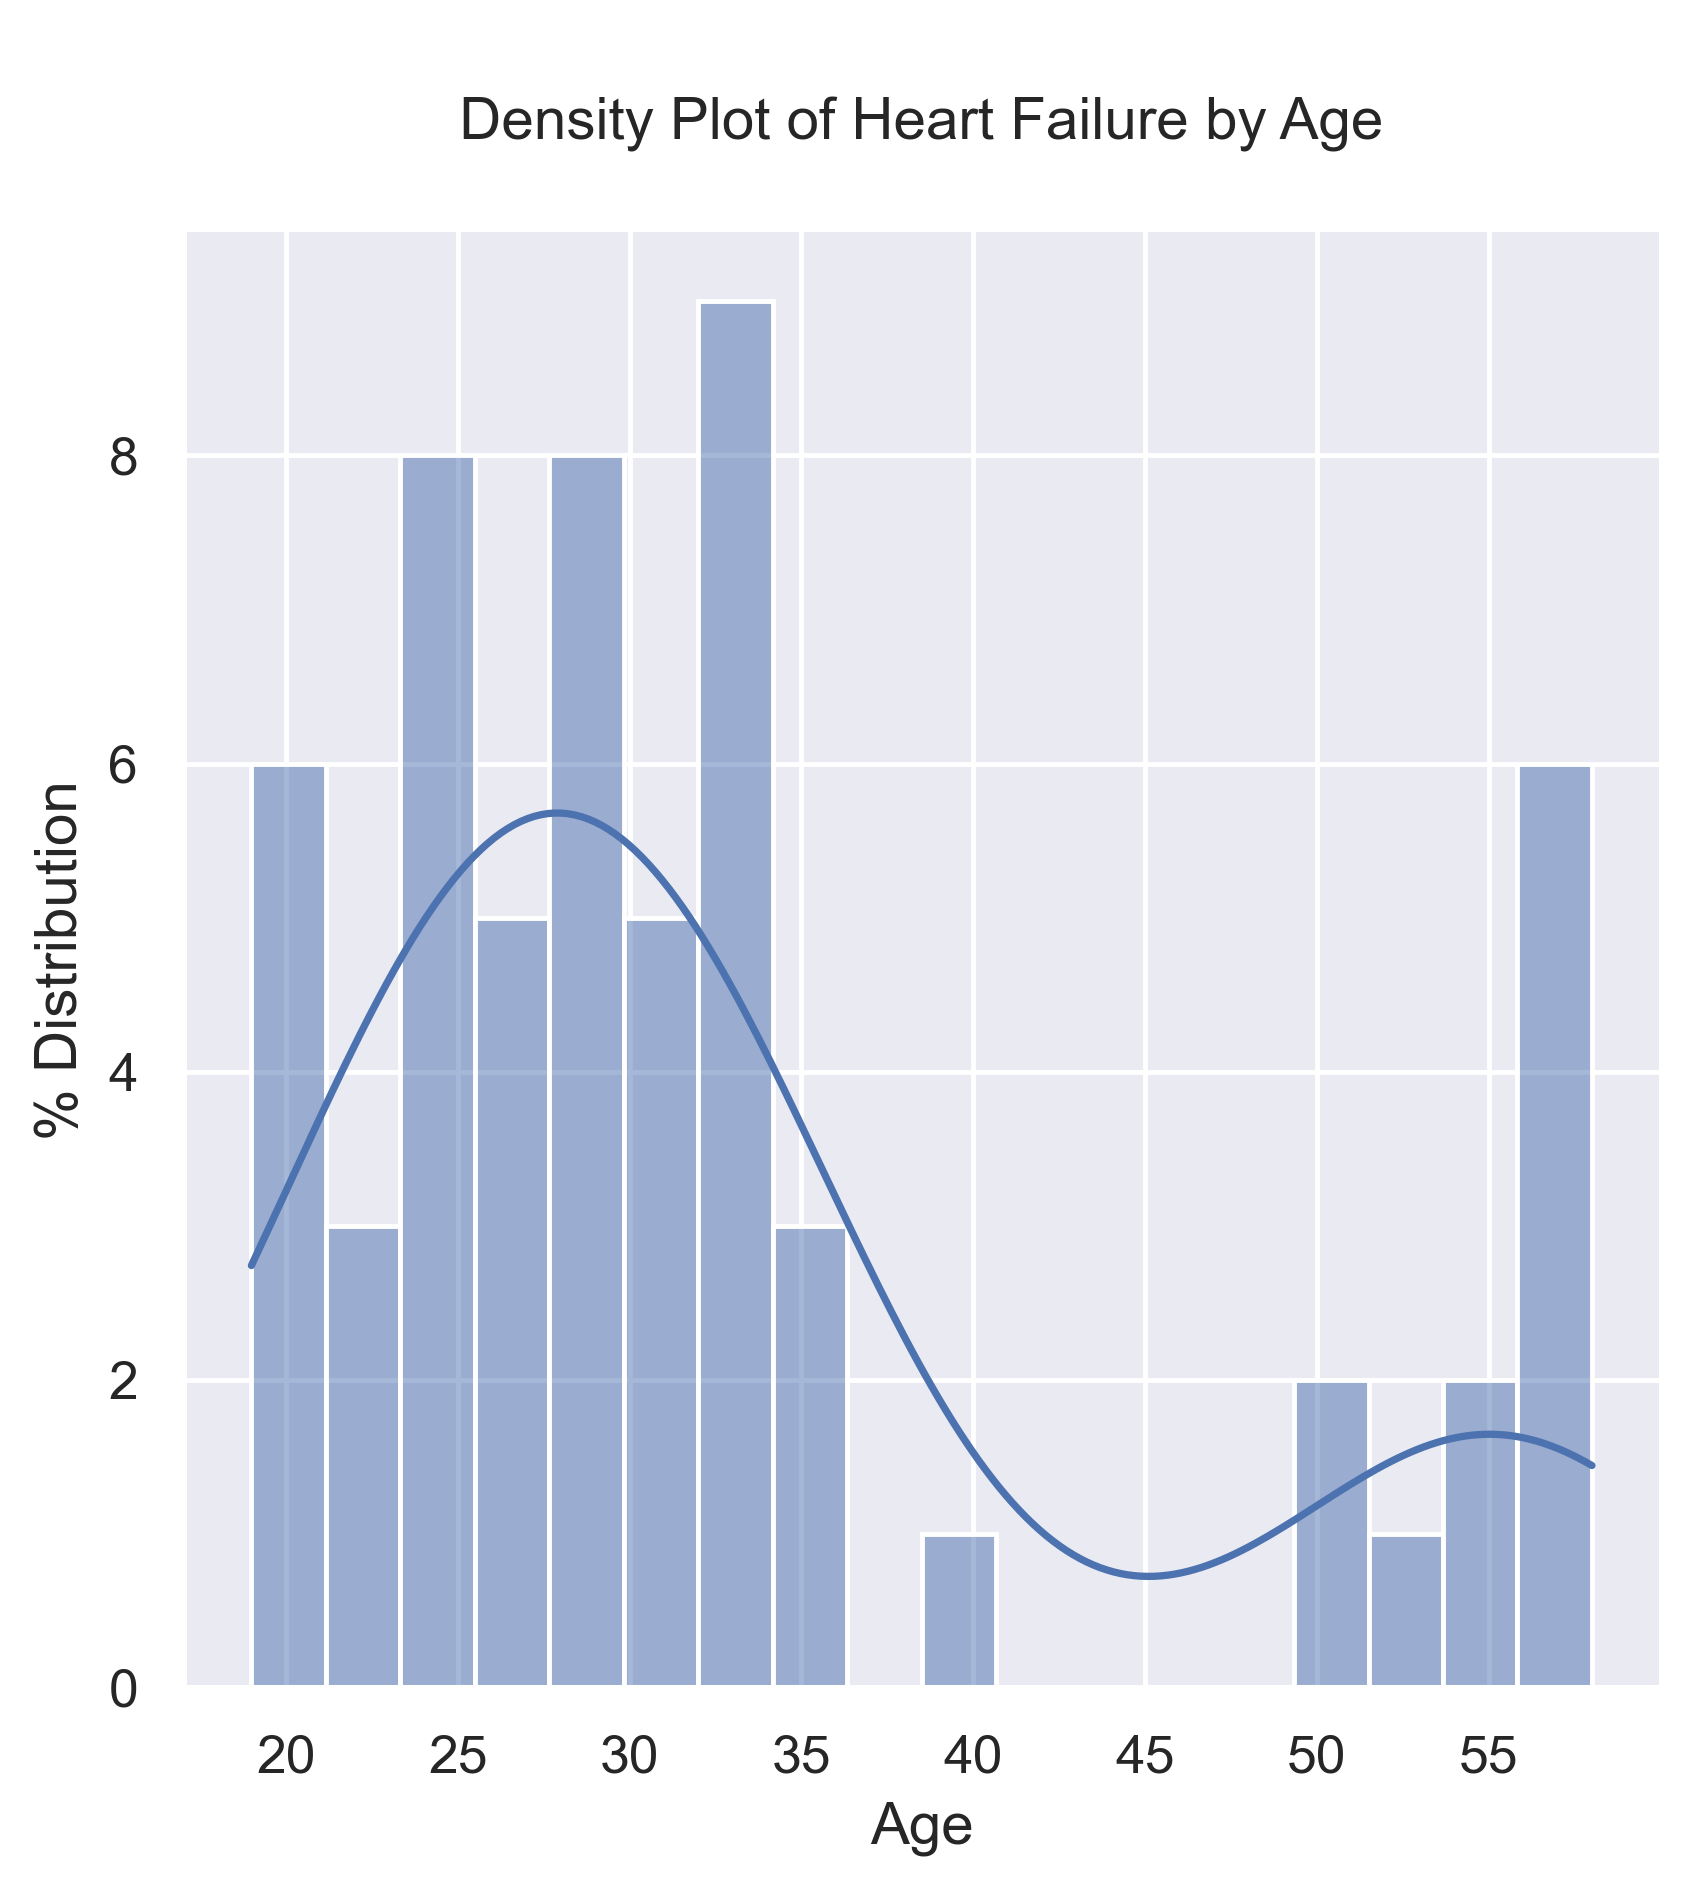

In [54]:
# Density Distribution by Age
ax=sns.displot(data.Age, kde=True, bins=18)
ax.set(xlabel='Age',
      ylabel='% Distribution',
      title='\n Age Range \n');

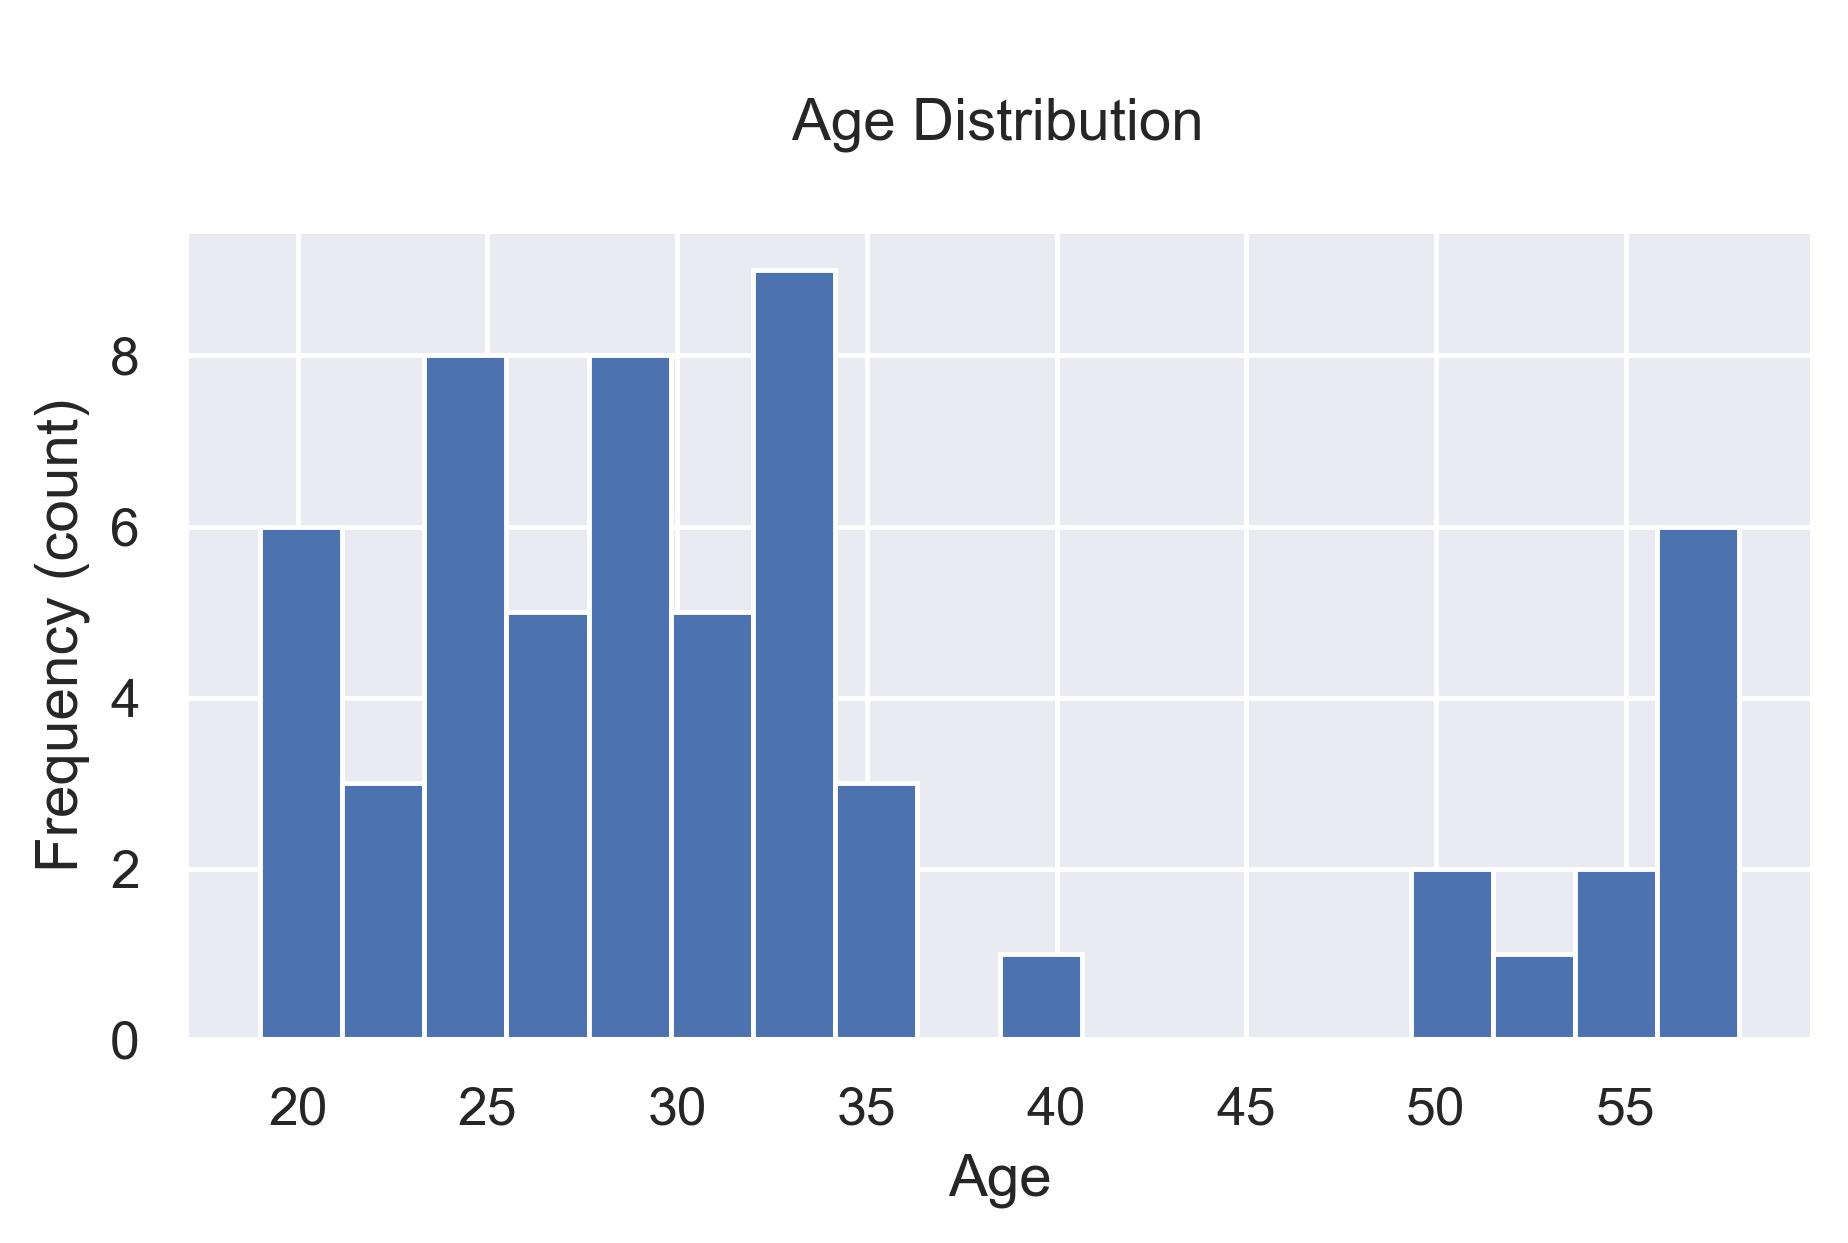

In [95]:
# Plot histogram of "AGE"
data['Age'].hist(bins = 18)
plt.xlabel('Age')
plt.ylabel('Frequency (count)')
plt.title('\n Age Distribution \n');

### Income

In [20]:
income_cat = data['Monthly Household Income'].unique()
print('Income Bracket:', income_cat)

Age Groups: ['< 50000' '100000 - 200000' '200000 - 500000' '50000 - 100000'
 '> 1000000' '500000 - 1000000']


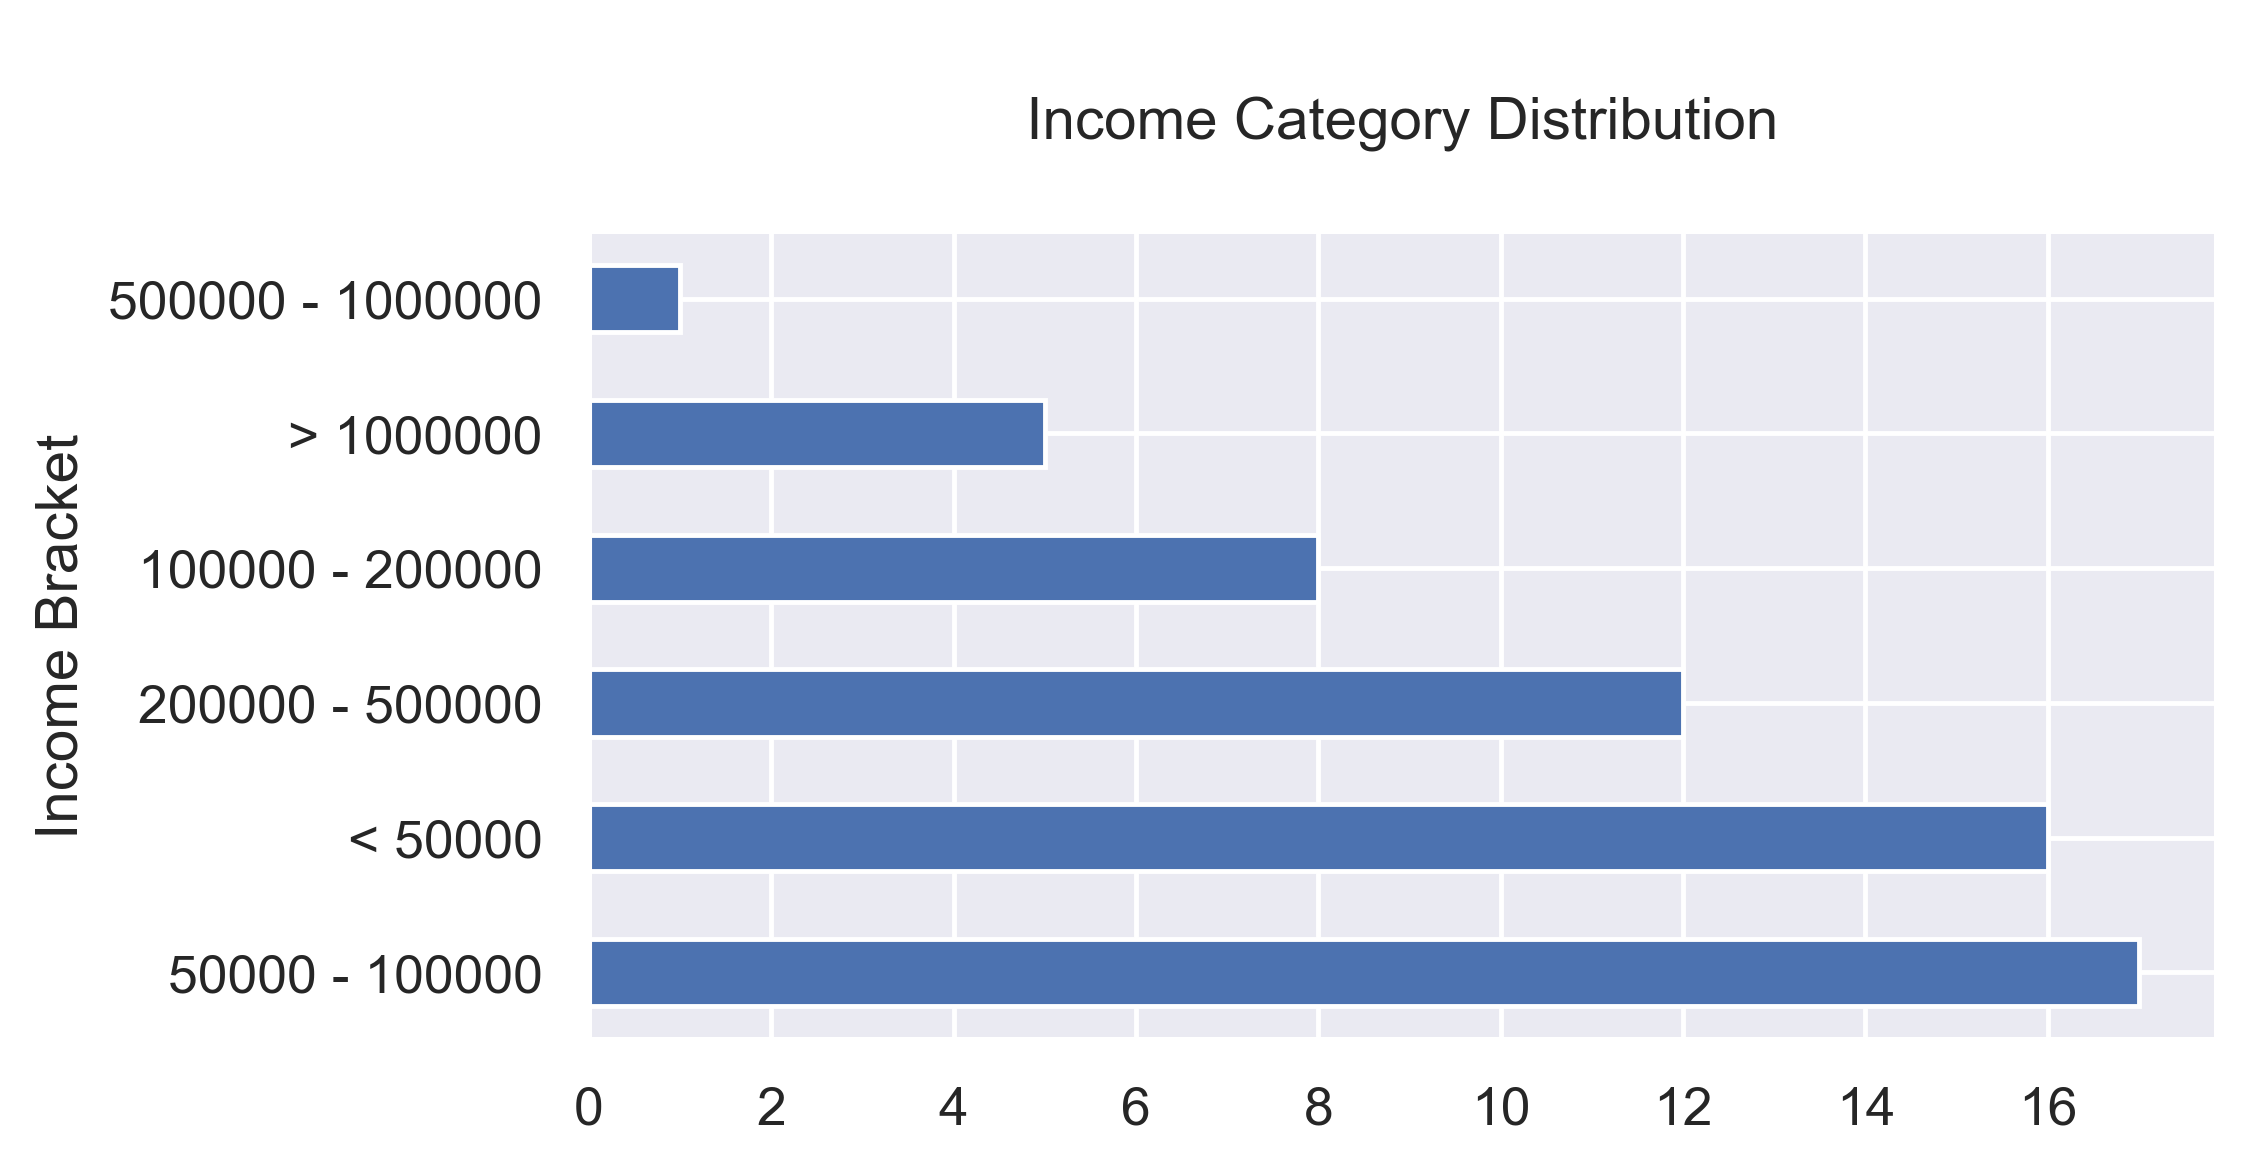

In [96]:
# Create bar chart of `df_inccat`
household_income_value_counts = data['Monthly Household Income'].value_counts()

# Bar plot of `age_cl_value_counts`
household_income_value_counts.plot(
    kind ='barh', 
    ylabel = 'Income Bracket',
    title = '\n Income Category Distribution \n'
);

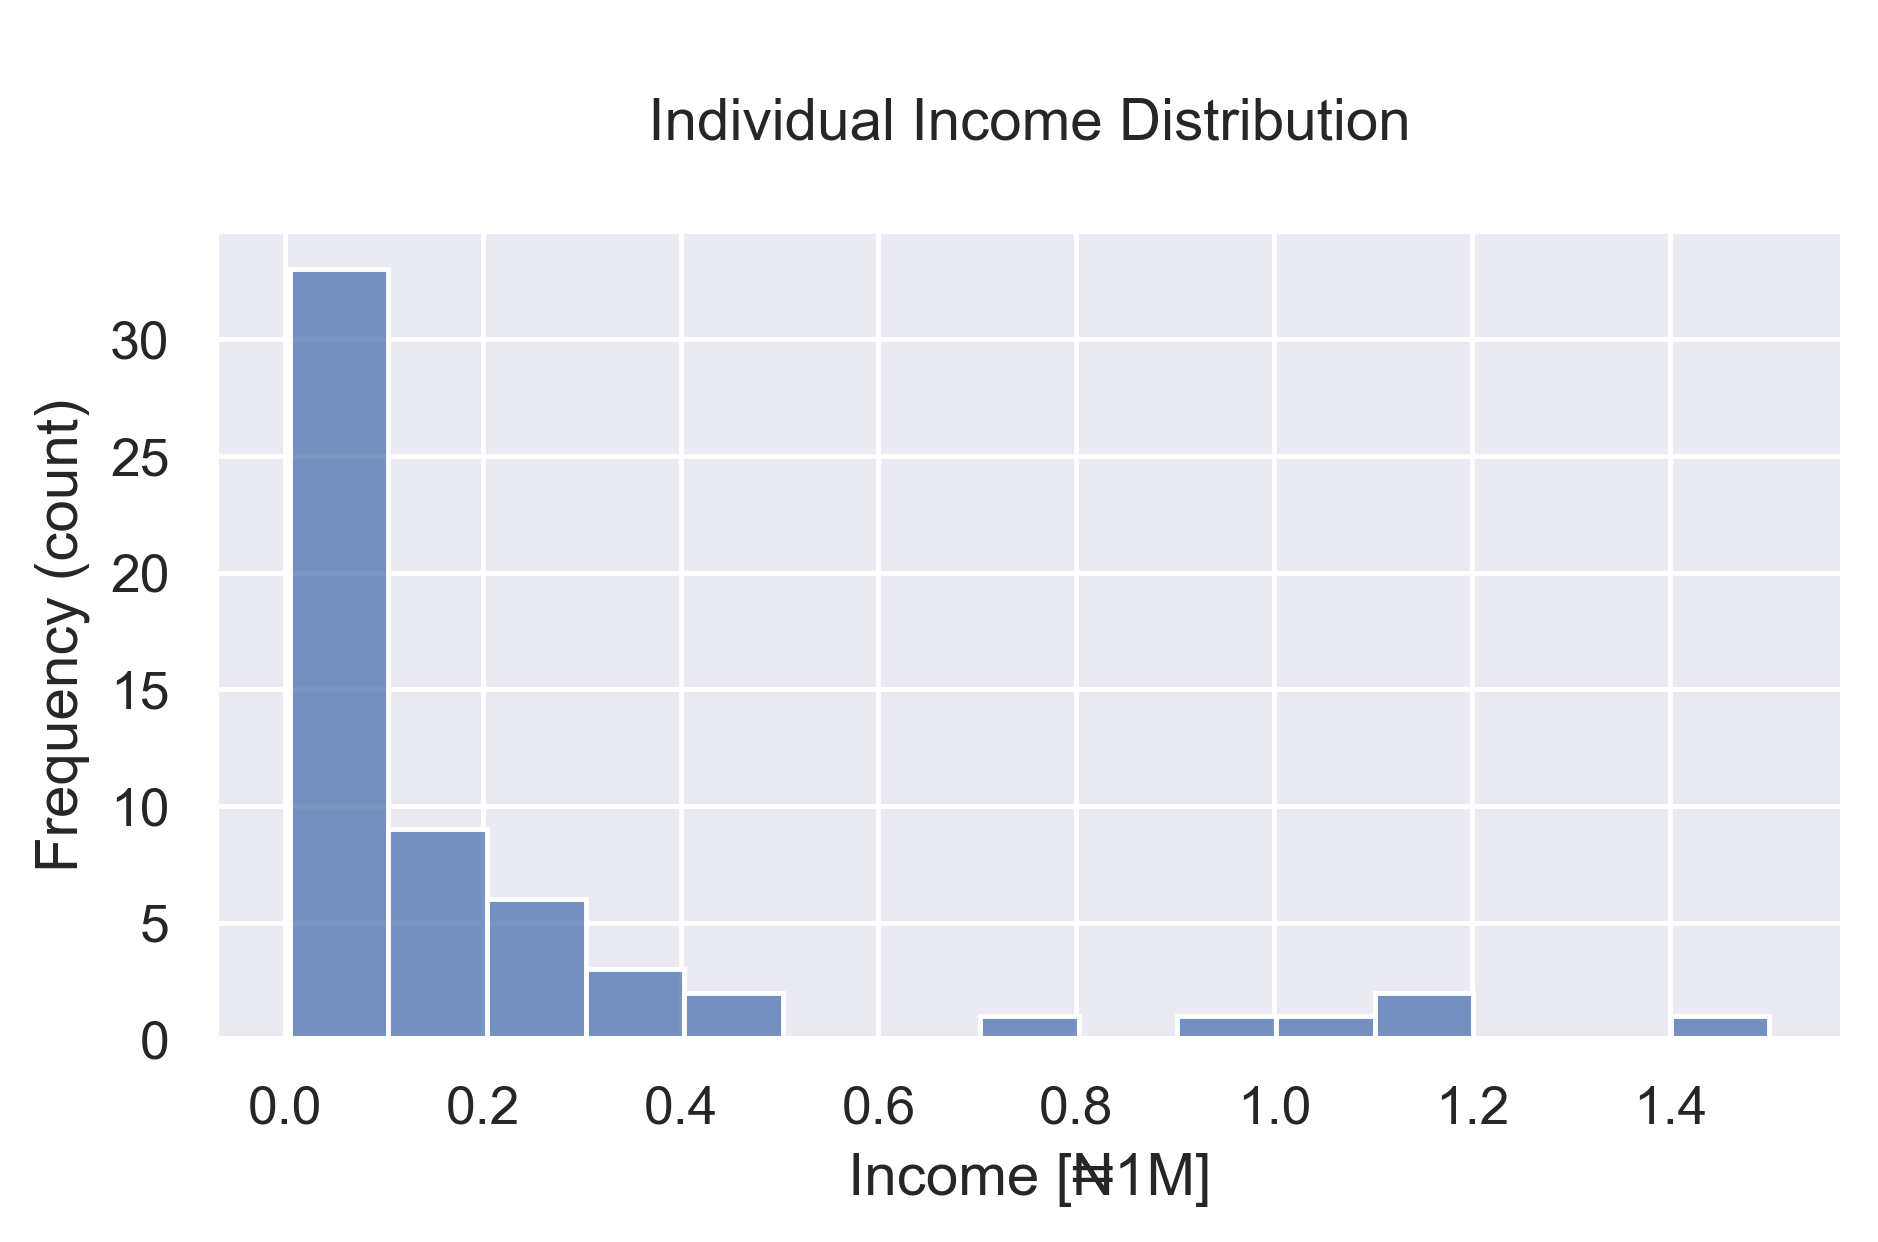

In [97]:
sns.histplot(data['Income'] / 1e6)
plt.xlabel('Income [₦1M]'),
plt.ylabel('Frequency (count)'),
plt.title('\n Individual Income Distribution \n');

### Occupation

In [23]:
job_groups = data['Occupation'].unique()
print("Job categories:", job_groups)

Age Groups: ['Student' 'Farmer' 'Freelance copywriter' 'Content Creator'
 'Business man' 'Designer' 'Medical Doctor' 'Teacher' 'Nurse'
 'Network marketer' 'Civil servant' 'Researcher' 'Digital marketer'
 'Banker' 'Not Specified' 'CNA' 'Accountant' 'Entrepreneur' 'Unemployed'
 'Butcher' 'Mechanic' 'Assisstant']


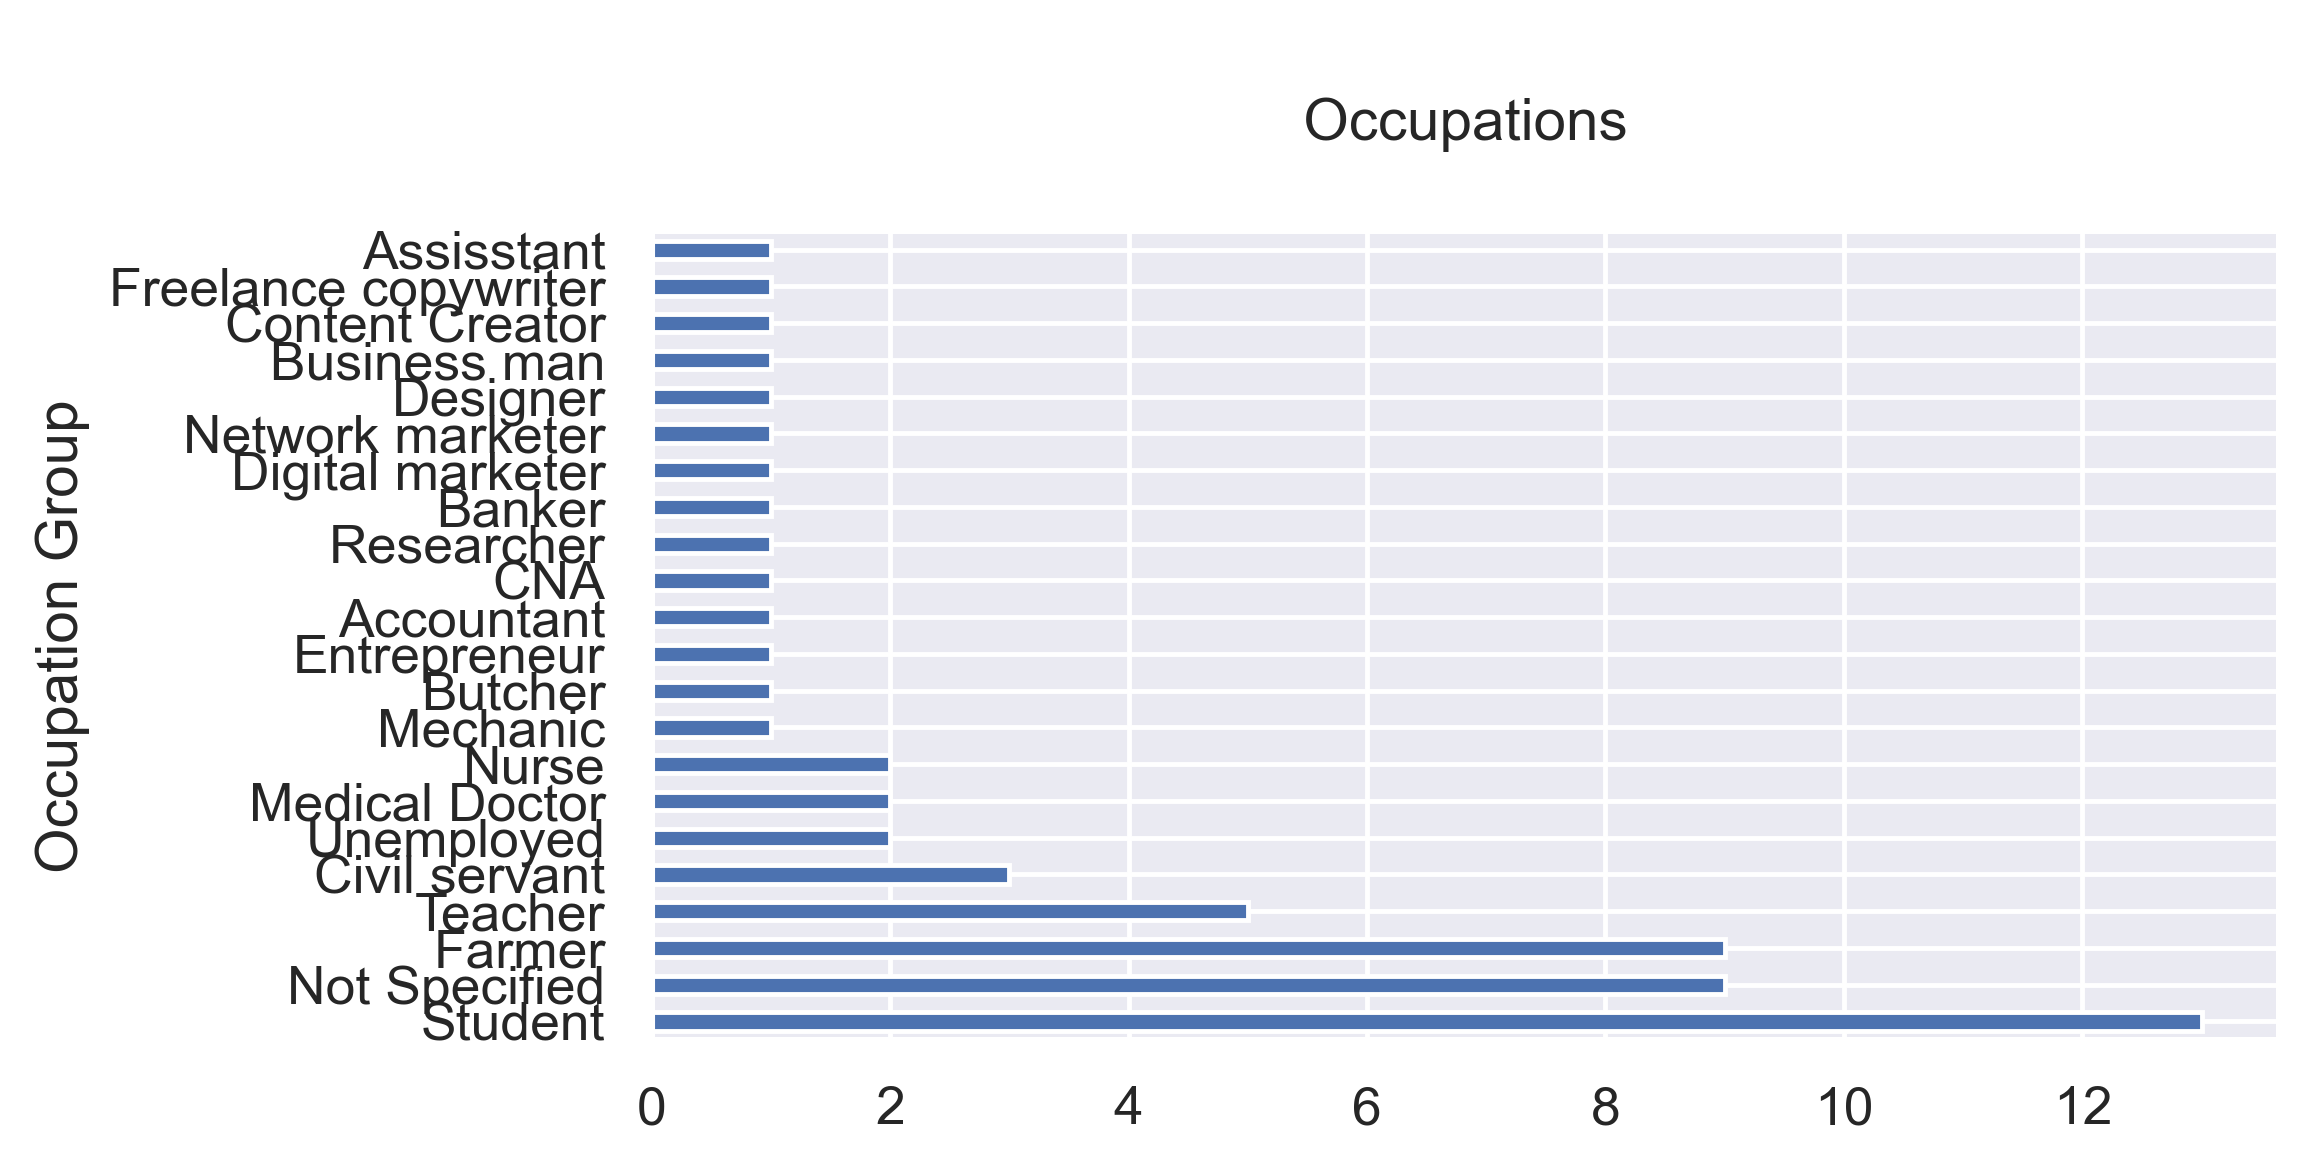

In [98]:
job_groups_value_counts = data['Occupation'].value_counts()

# Bar plot of `jobs_value_counts`
job_groups_value_counts.plot(
    kind ='barh', 
    xlabel = 'Occupation Group',
    ylabel = 'Frequency (count)',
    title = '\n Occupations \n'
);

    Most are students.

### Relation between `Age` and `Income`

In [157]:
X = data[['Age', 'Income']]
# Build model
model = KMeans(n_clusters=3, random_state=42)
# Fit model to data
model.fit(X)

KMeans(n_clusters=3, random_state=42)

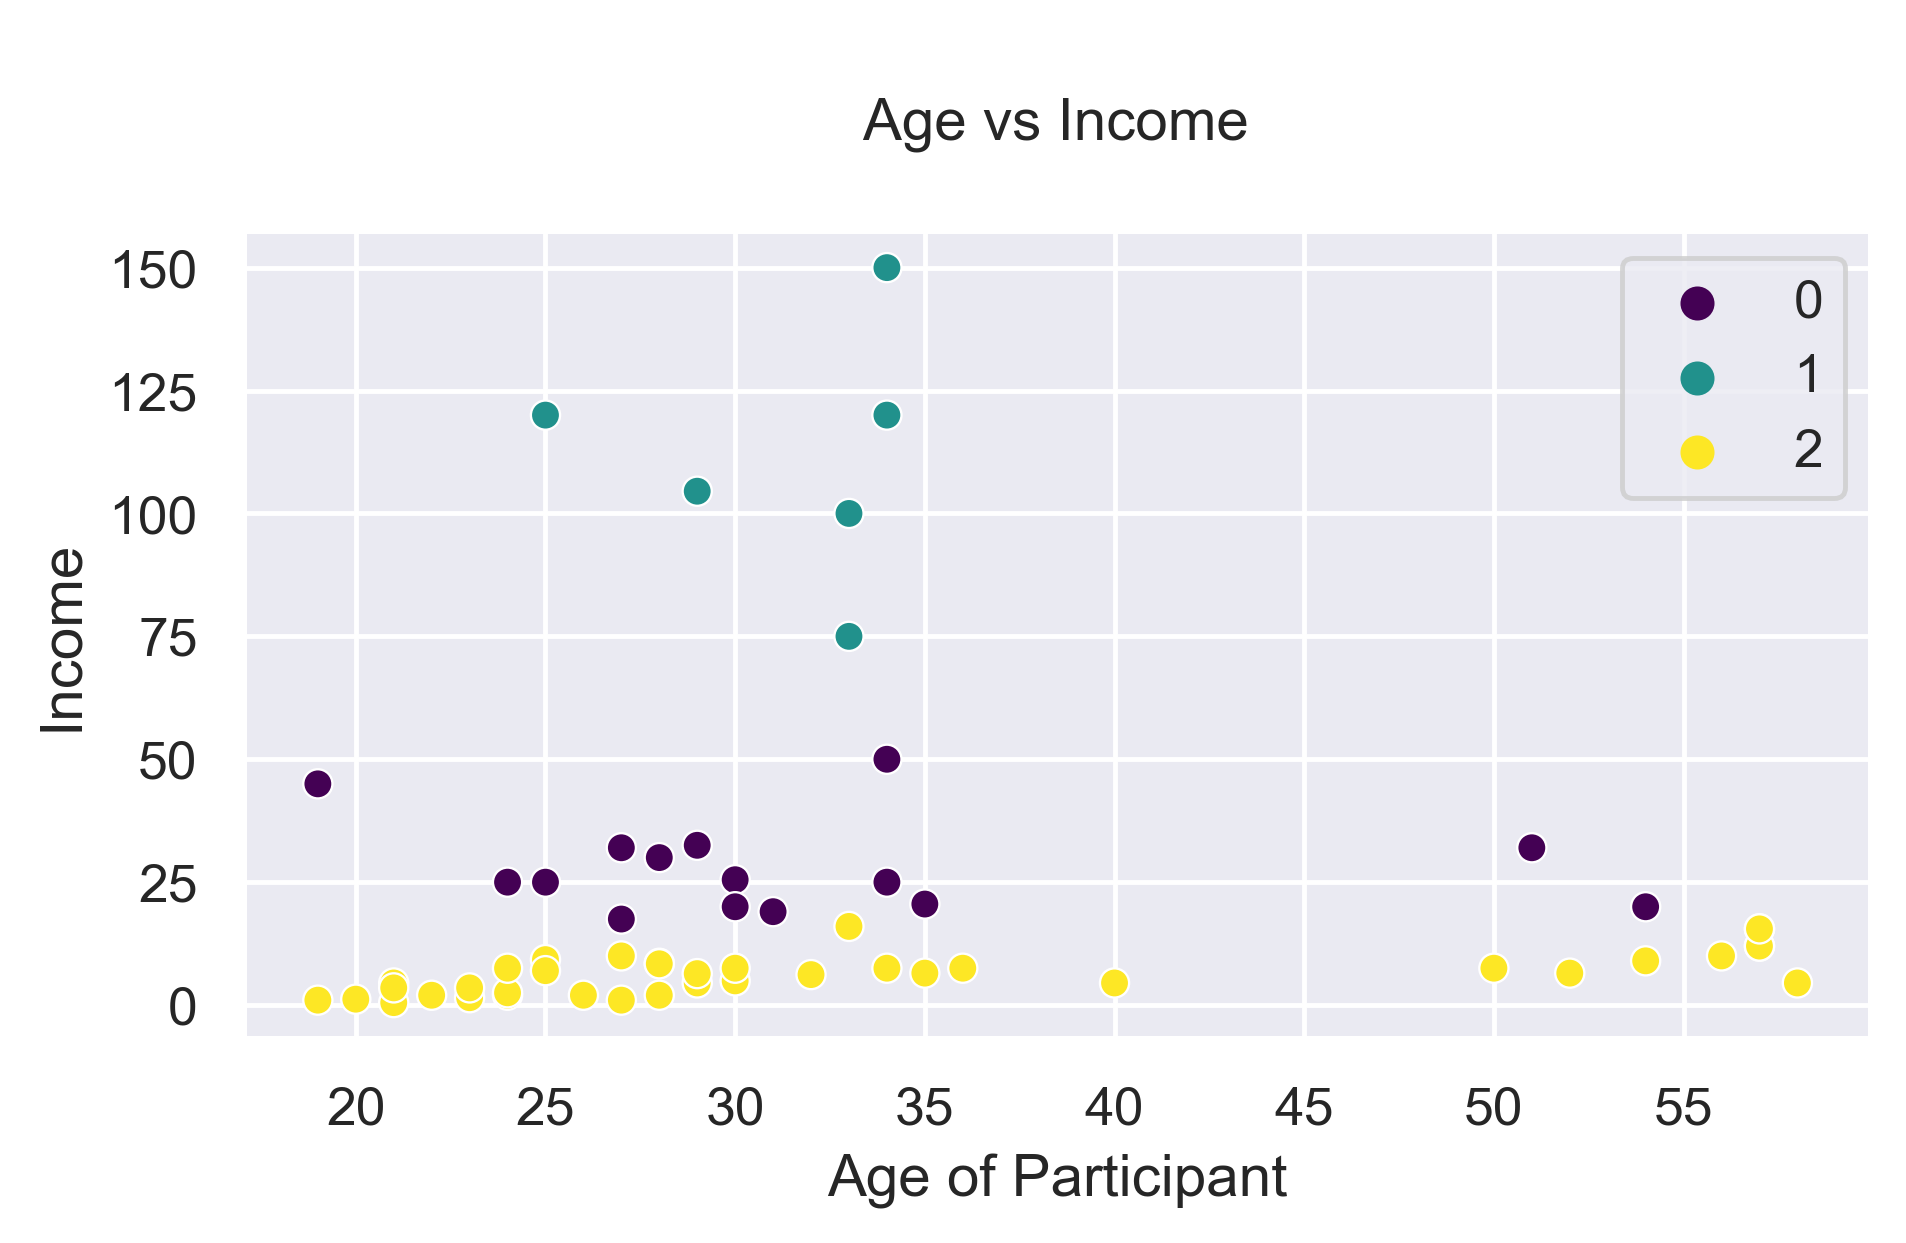

In [158]:
# 'Age' vs 'Income' with hue=label
sns.scatterplot(
    x=data['Age'],
    y=data['Income']/1e4,
    hue=model.labels_,
    palette='viridis'
)
plt.xlabel('Age of Participant')
plt.ylabel('Income')
plt.title('\n Age vs Income \n');

- Plot to show relationship between `Age` and `Income`

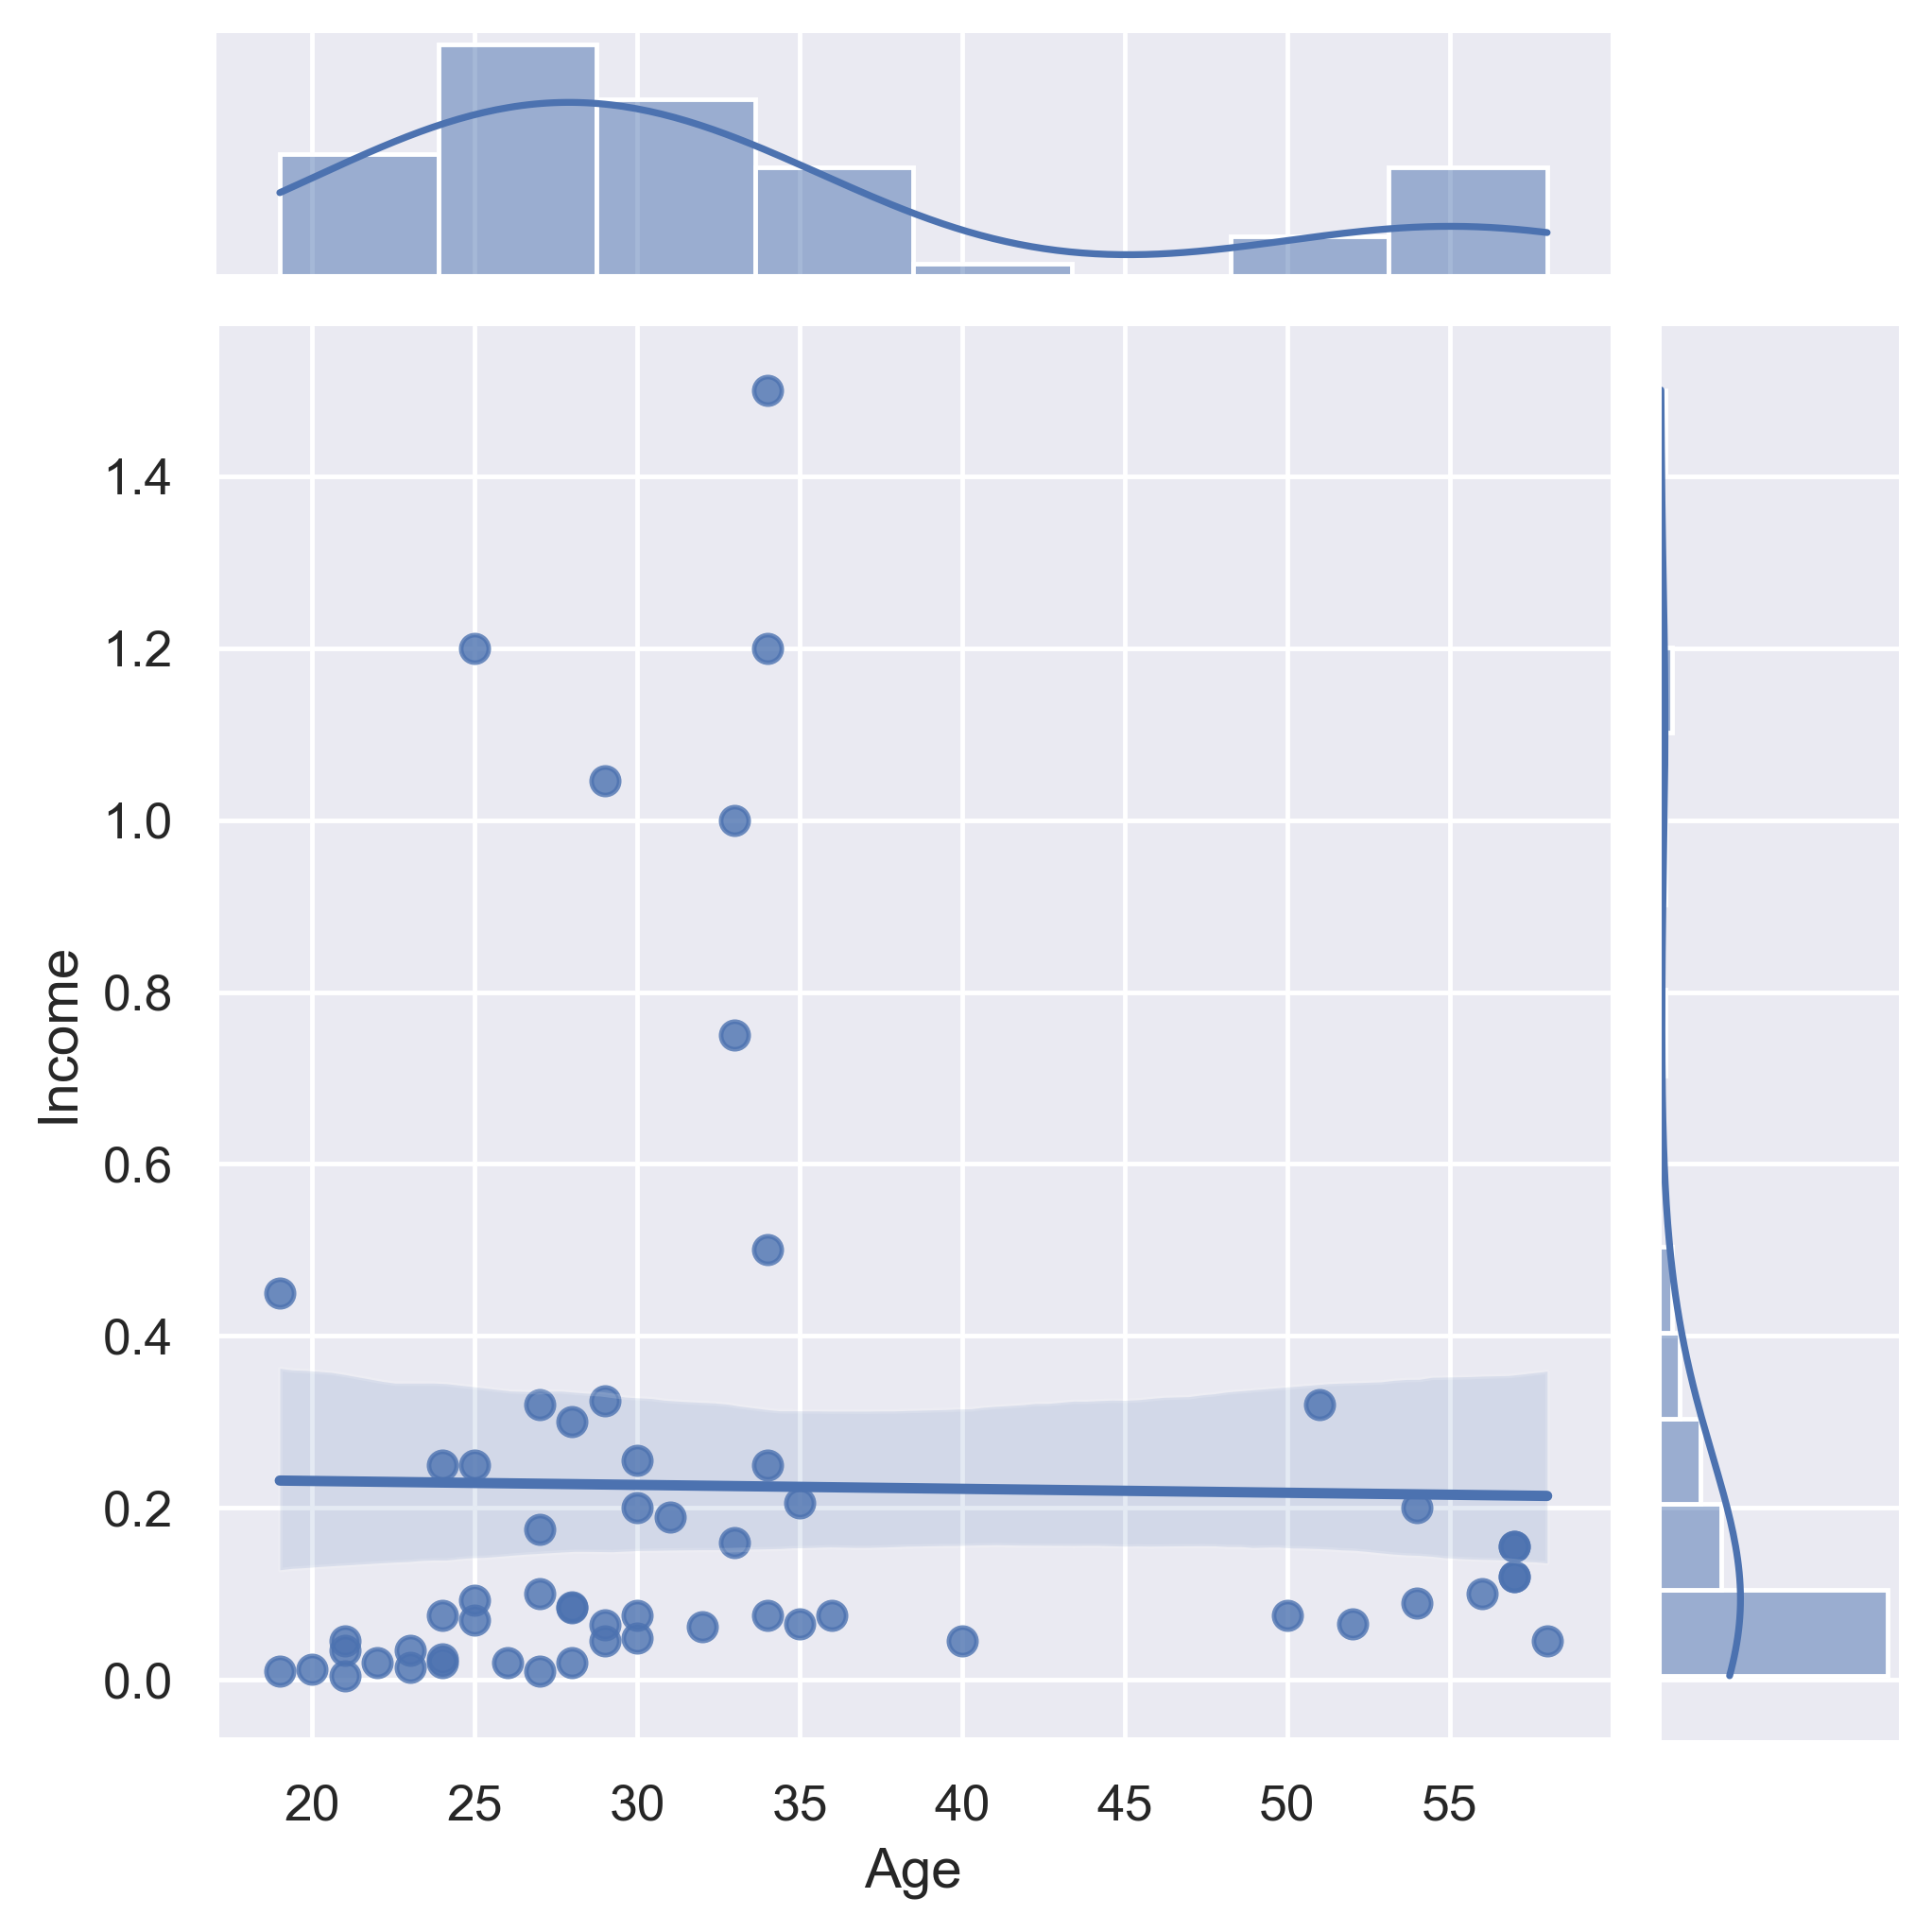

In [59]:
sns.jointplot(x = 'Age', y = data['Income']/1e6, data = data, kind='reg');

    Not correlated

# Wrangling

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age Range                       59 non-null     object 
 1   Age                             59 non-null     int64  
 2   Gender                          59 non-null     object 
 3   Occupation                      59 non-null     object 
 4   Marital status                  59 non-null     object 
 5   Income                          59 non-null     float64
 6   Monthly Household Income        59 non-null     object 
 7   Location                        59 non-null     object 
 8   Device Type                     59 non-null     object 
 9   Delivery Method                 59 non-null     object 
 10  Farmer                          59 non-null     object 
 11  Farm Produce                    59 non-null     object 
 12  Online Platform                 59 non

- check cardinality

In [28]:
data.nunique()

Age Range                          4
Age                               26
Gender                             2
Occupation                        22
Marital status                     2
Income                            38
Monthly Household Income           6
Location                          13
Device Type                        2
Delivery Method                    4
Farmer                             2
Farm Produce                      51
Online Platform                    3
Alternative Platform Knowledge     3
Digital Platform Features         22
dtype: int64

In [29]:
#out = (high)Farmproduce, income,(low)status, gender,device, farmer, online, knowlegde, delivey, 

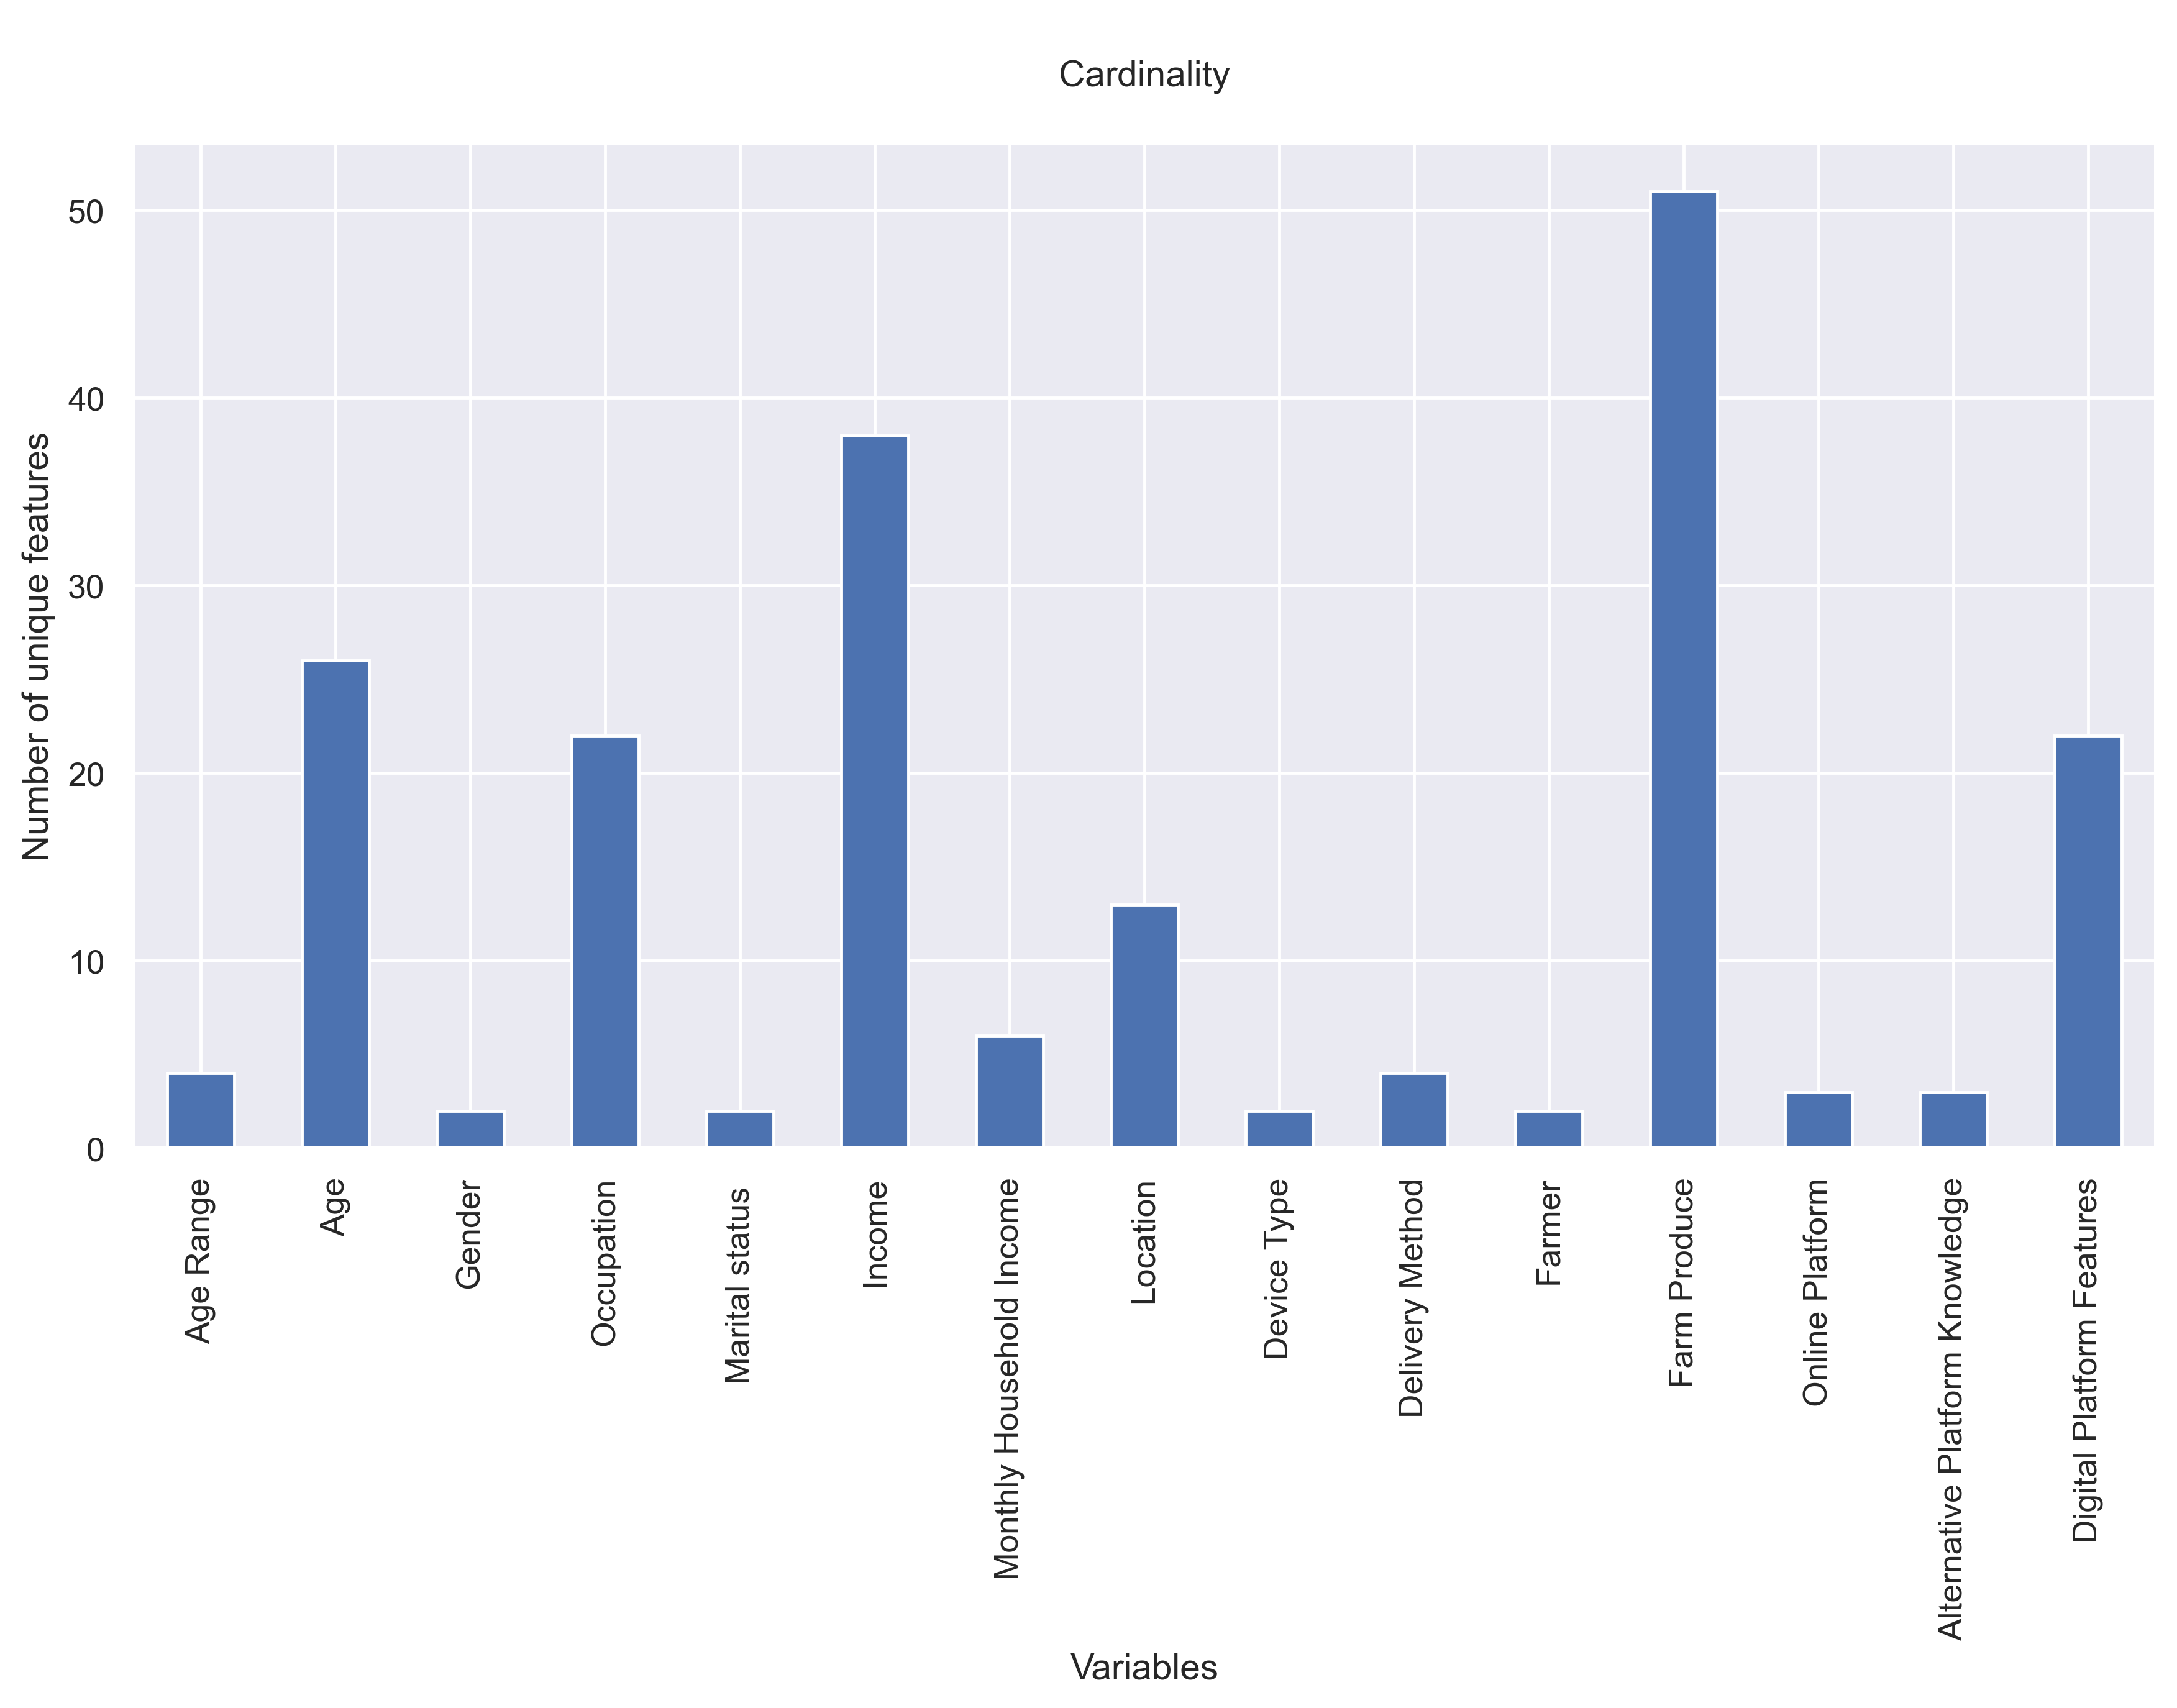

In [100]:
# plot of cardinality
data.nunique().plot.bar(figsize=(12, 6))
plt.xlabel('Variables')
plt.ylabel('Number of unique features')
plt.title('\n Cardinality \n');

In [101]:
# boxplot of `Income`
fig = px.box(
    data_frame = data['Income']/1e6,
    x = 'Income',
    title = '\n Distribution of Income \n')

fig.update_layout(xaxis_title = 'Value [₦M]')

fig.show()

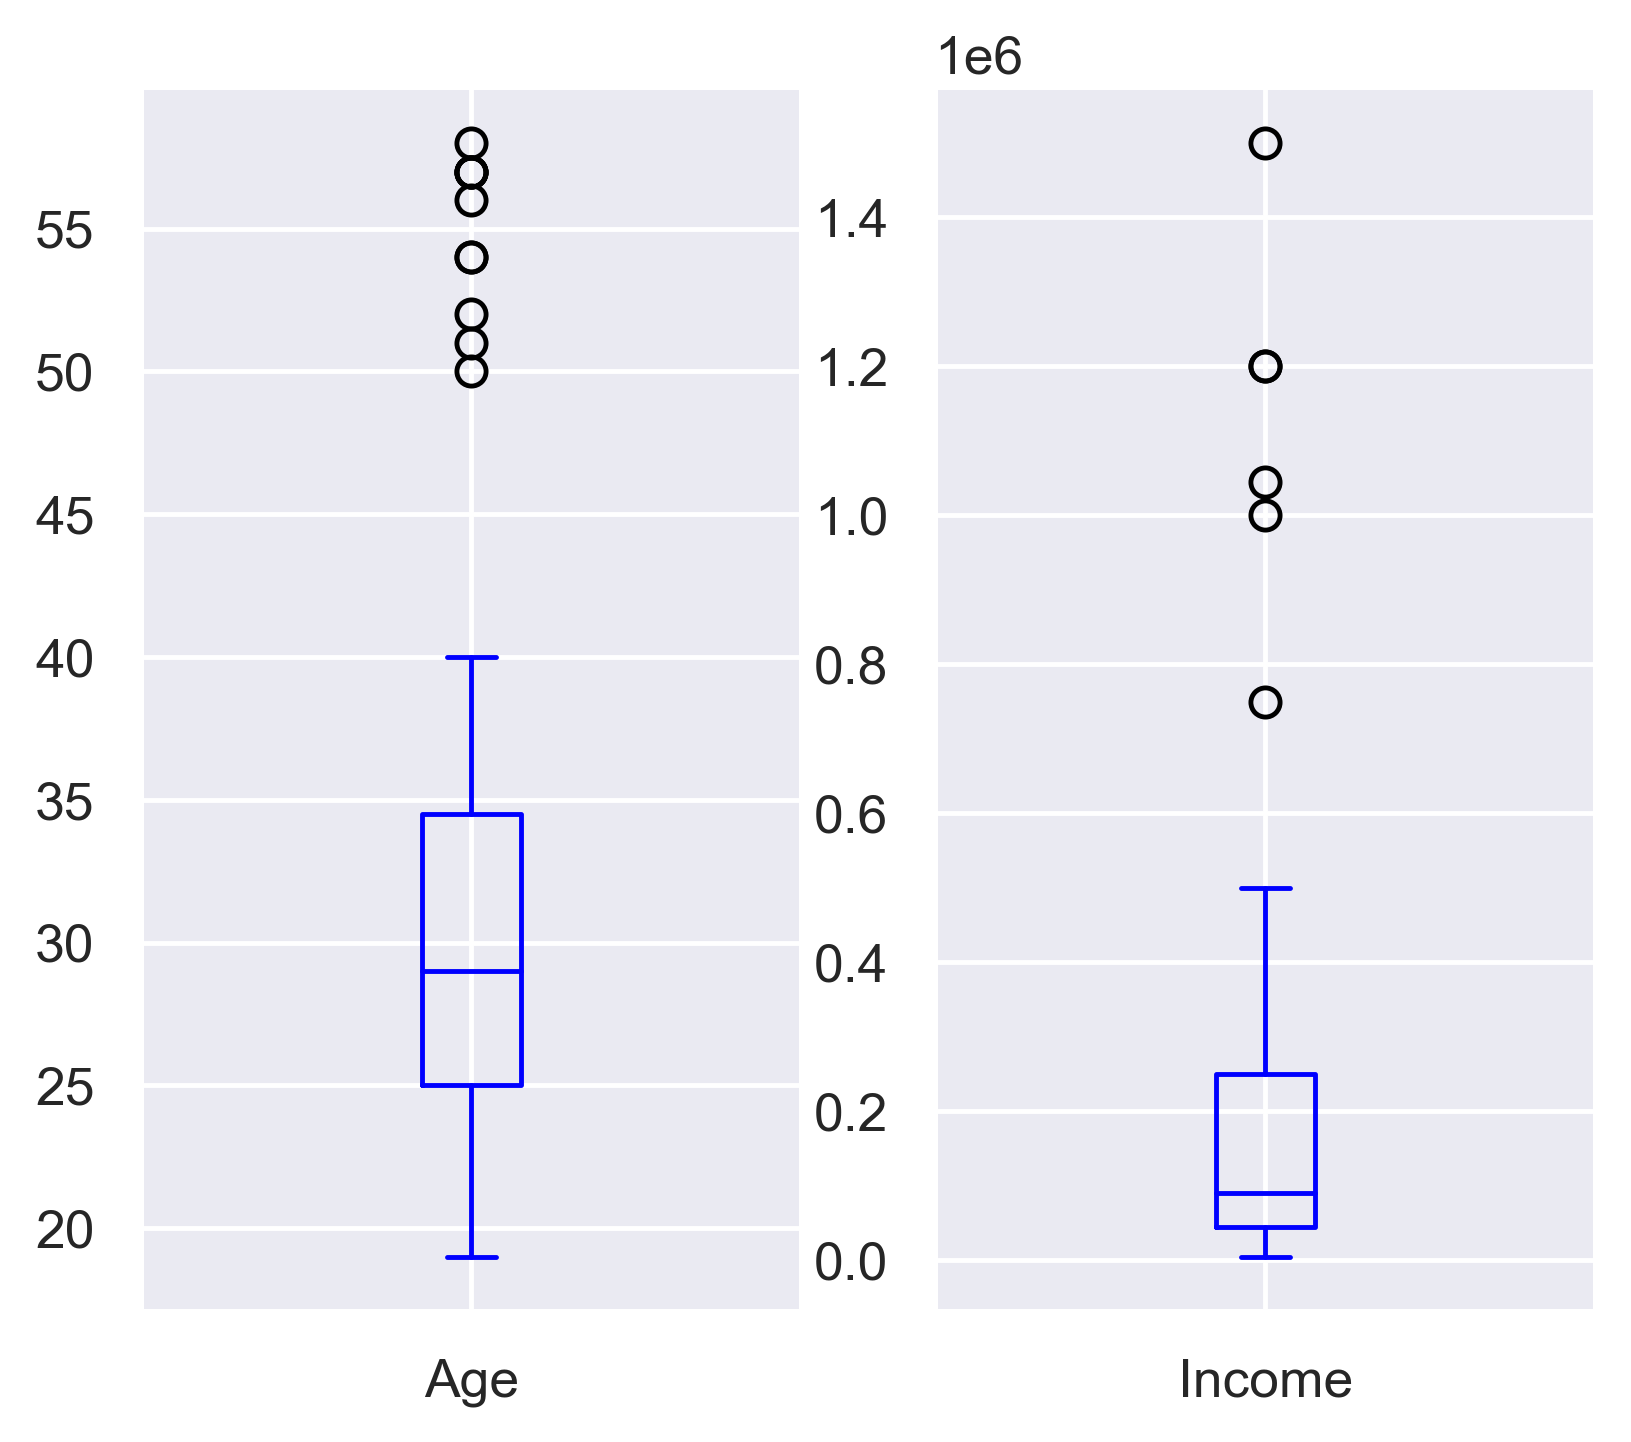

In [94]:
# A look at the outliers
data.plot(kind = 'box', subplots = True, layout=(2, 7),
       sharex= False, sharey= False, figsize=(20,10),
       color='blue');

    This dataset is right-skewed because of the outliers on the right side of the distribution.

In [32]:
# variance
data['Income'].var()

108582808663.06252

In [33]:
# trimmed variance
trimmed_var(data['Income'])

20106036026.65556

In [103]:
features = ['Age', 'Income', 'Occupation', 'Location']

In [72]:
# make copy of original df
df = data[features].copy()

In [117]:
from kmodes.kprototypes import KPrototypes

kproto = KPrototypes(n_clusters=4, init='Cao')

clusters = kproto.fit_predict(df_norm, categorical=[2, 3])
#join data with labels
labels = pd.DataFrame(clusters)
labeledCustomers = pd.concat((df, labels), axis=1)
labeledCustomers = labeledCustomers.rename({0: 'labels'}, axis=1)

In [ ]:
#make plot

In [118]:
df_norm = pd.get_dummies(df_norm, columns=['Occupation','Location'])
df_norm.head()

,Age,Income,Occupation_Accountant,Occupation_Assisstant,Occupation_Banker,Occupation_Business man,Occupation_Butcher,Occupation_CNA,Occupation_Civil servant,Occupation_Content Creator,...,Location_Ekiti,Location_Ibadan,Location_Ife,Location_Lagos,Location_Lagos,Location_Modakeke,Location_Modakeke,Location_Osun,Location_Osun,Location_Oyo
0,0.051282,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.974359,0.076923,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.974359,0.100334,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.102564,0.006689,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0.230769,0.197324,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [119]:
n_clusters = range(2, 10)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    # train model
    model.fit(df_norm)
    # calculate inertia
    inertia_errors.append(model.named_steps['kmeans'].inertia_)
    # calculate silhoutte score
    silhouette_scores.append(
        silhouette_score(df_norm, model.named_steps['kmeans'].labels_)
    )
    
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [2064.601079183341, 1980.8496404315638, 1903.4218116232796]

Silhouette Scores: [0.12586072260384085, 0.1014113447419192, 0.11991117167628512]


In [120]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x = n_clusters,
    y = inertia_errors,
    title = 'KMeans Model: Inertia vs Number of Clusters'
)

fig.update_layout(
    xaxis_title = 'Number of Clusters',
    yaxis_title='Inertia'
)

fig.show()

    k on 5

In [121]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x= n_clusters,
    y= silhouette_scores,
    title= 'K-Means Model: Silhouette Score vs Number of Clusters'
)
fig.update_layout(
    xaxis_title= 'Number of Clusters (k)',
    yaxis_title= 'Silhouette Score'
)
fig.show()

    k = 6

In [126]:
kmeans = KMeans(n_clusters=6)

clusters = kmeans.fit_predict(df_norm)
labels = pd.DataFrame(clusters)
labeledCustomers = pd.concat((df, labels), axis=1)
labeledCustomers = labeledCustomers.rename({0: 'labels'}, axis=1)

In [142]:
labeledCustomers.head()

,Age,Income,Occupation,Location,labels
0,21,5000.0,Student,Modakeke,1
1,57,120000.0,Student,Osun,0
2,57,155000.0,Farmer,Osun,4
3,23,15000.0,Student,Ekiti,1
4,28,300000.0,Freelance copywriter,Ibadan,2


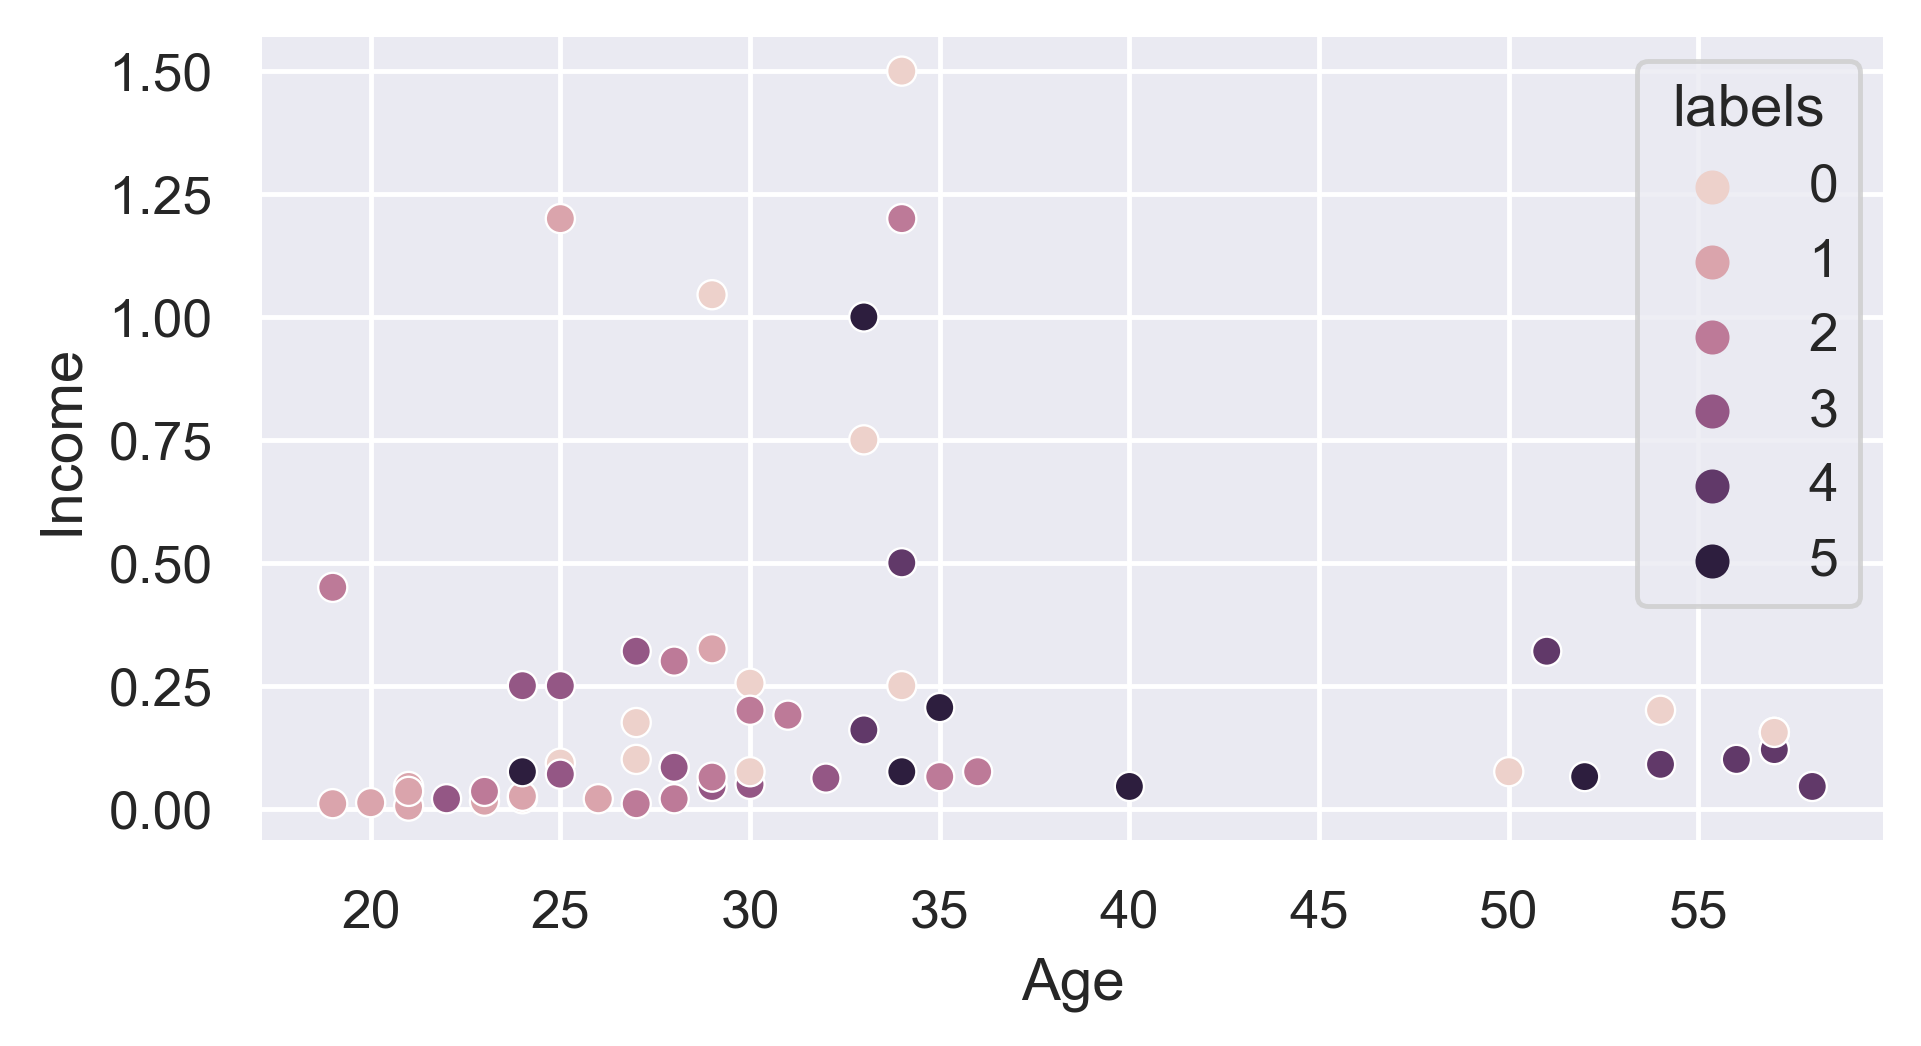

In [159]:
sns.scatterplot(x='Age', y=df['Income']/1e6, data=labeledCustomers, hue='labels');

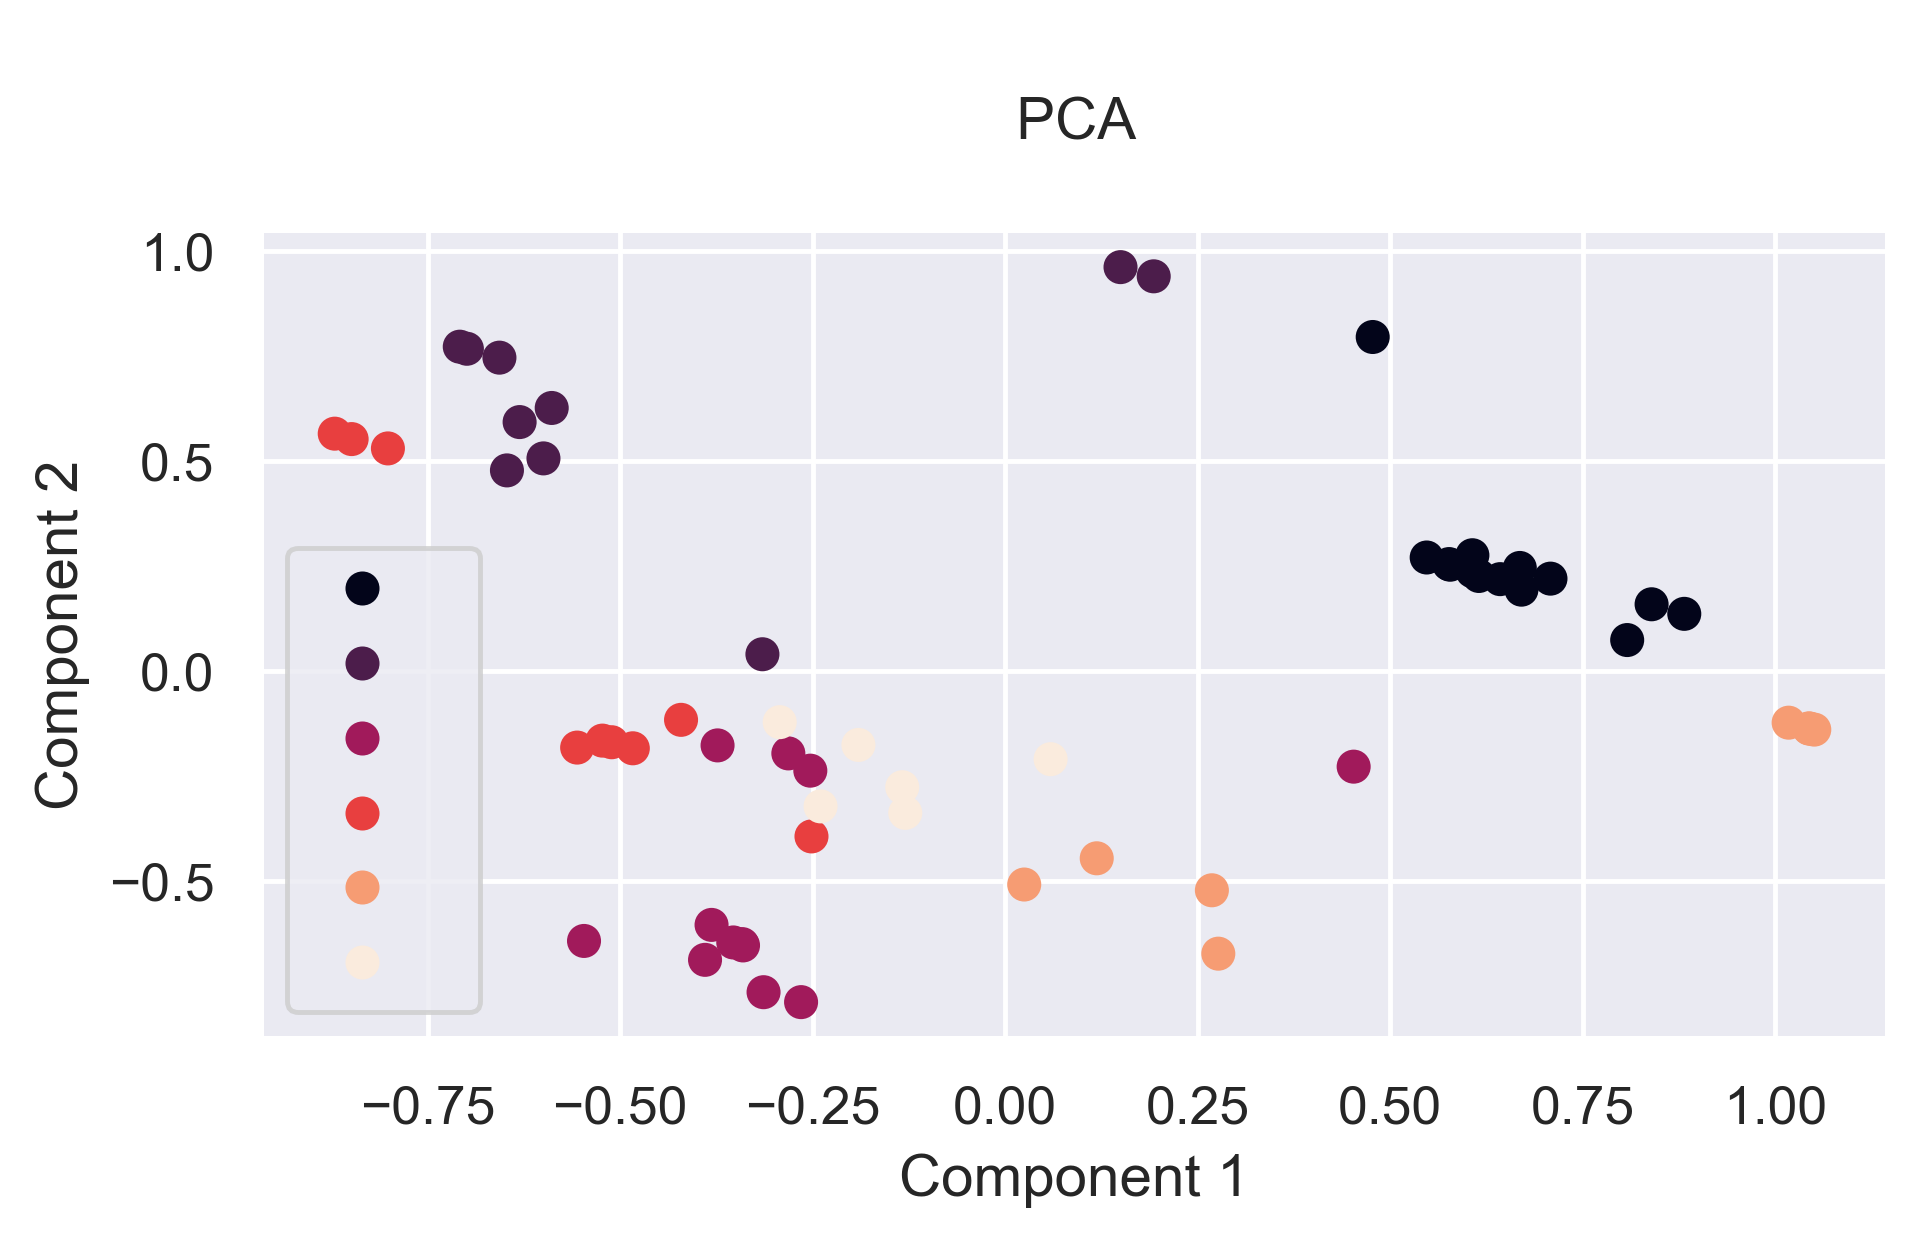

In [161]:
# instantiate transformer
pca = PCA(n_components=2, random_state=42)
# transform `X`
X_t = pca.fit_transform(df_norm)
# make scatter plot of clusters
plot = plt.scatter(X_t[:,0], X_t[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('\n PCA \n')
plt.show();

# References

1.Data dictionary source code, 
https://github.com/p-easter/Python_DataDictionary/blob/main/README.md

In [ ]:
#data_d = pd.read_csv('data_dictionary.csv')
#data_d